# Main Tasks
1. Packages
2. Datasets
3. Goal
4. Data preprocessing - missing values imputation
    - 4.1 Numerical features
        - (4.1.1 － 4.1.6): Deal with numerical features containing at least 80% NA values.
            - 4.1.1 Irrelevant features
            - 4.1.2 Joint-type features
            - 4.1.3 Secondary applicant related features
            - 4.1.4 Hardship related features
            - 4.1.5 Settlement related features
            - 4.1.6 Other numerical features
        - (4.1.7): Deal with numerical features containing at least 1 NA vlaue.
    - 4.2 Categorical features
        - (4.2.1 － 4.1.4): Deal with categorical features containing at least 80% NA values.
            - 4.2.1 Irrelevant features
            - 4.2.2 Hardship related features
            - 4.2.3 Settlement related features
            - 4.2.4 Other features
        - (4.2.5) Other categorical features containing at least one NA value.
5. Feature transformation
    - 5.1 Datetime type features transformation
    - 5.2 Features with a wrong data type
    - 5.3 Categorical features with too many levels
    - 5.4 Final check
6. Outliers imputation
7. Feature selection by feature significance
    - 7.1 Numerical type of features: using t-test
    - 7.2 Categorical type of features: using chi-square test
8. Save the final dataset into a csv file for a later model fitting operation

## 1. Packages

In [1]:
import pandas as pd
import numpy as np

import math
import time

from scipy import stats
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## 2. Dataset
- Description: LoanStats_2018Q1.csv contains loan application records from January 2018 to March 2018.
    - 107866 loan applications.
    - 145 features.

In [2]:
loan = pd.read_csv("/Users/wuchenhong/Documents/Bittiger/Capstone/LoanStats_2018Q1.csv", header = 1, 
                   low_memory = False)

In [3]:
# 107866 loan applications and 145 columns
print(loan.shape)
loan.head()

(107866, 145)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,7000.0,7000.0,7000.0,36 months,7.34%,217.23,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,5000.0,5000.0,5000.0,36 months,7.96%,156.59,A,A5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,17000.0,17000.0,17000.0,36 months,10.90%,555.76,B,B4,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,20000.0,20000.0,20000.0,36 months,5.31%,602.21,A,A1,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,25000.0,25000.0,25000.0,60 months,12.61%,563.85,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Goal
- Four interesting problems (demonstrated as columns below) can be solved given this dataset.
    - grade
    - sub_grade
    - int_rate
    - loan_status
- For this jupyter notebook, I mainly focus in loan_status. 
    - My goal is trying to predict the loan repayment capacity for each loan applicant of each loan application. Furthermore, I started by creating a boolean type of loan_status.

In [4]:
# My goal is to predict the loan status 
# Response variable, loan_status, has two NA values
loan.loan_status.isnull().sum()

2

In [5]:
# Exclude two NA values in loan_status
# 107864 loan applications and 145 columns
loan = loan[loan.loan_status.notnull()]
print(loan.shape)

(107864, 145)


In [6]:
# Create loan_status_binary, my target response variable 

# 1 means a loan_status is either Fully Paid or Current
# 0 means the rest values of loan_status 
loan_status_binary = [1 if each in ['Fully Paid', 'Current'] else 0 for each in loan.loan_status.values]

# double-check
print(len(loan_status_binary))

107864


In [7]:
# Most of loan applications labeled with 1 (either Fully Paid or Current)
loan['loan_status_binary'] = loan_status_binary
loan['loan_status_binary'].value_counts() / loan.shape[0]

1    0.976647
0    0.023353
Name: loan_status_binary, dtype: float64

## 4. Data preprocessing - missing values imputation
- 4.1 Numerical features
    - (4.1.1 － 4.1.6): Deal with numerical features containing at least 80% NA values.
        - 4.1.1 Irrelevant features
        - 4.1.2 Joint-type features
        - 4.1.3 Secondary applicant related features
        - 4.1.4 Hardship related features
        - 4.1.5 Settlement related features
        - 4.1.6 Other numerical features
    - (4.1.7): Deal with numerical features containing at least 1 NA vlaue.
    
- 4.2 Categorical features
    - (4.2.1 － 4.1.4): Deal with categorical features containing at least 80% NA values.
        - 4.2.1 Irrelevant features
        - 4.2.2 Hardship related features
        - 4.2.3 Settlement related features
        - 4.2.4 Other features
    - (4.2.5) Other categorical features containing at least one NA value.

#### 4.1 NA value imputation in numerical type of features

In [8]:
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() >= loan.shape[0] * 0.8:
            print('More than 80% NA values', each, loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'numerical type of features contain 80% of NA values.')

More than 80% NA values member_id 107864 NA values.
More than 80% NA values url 107864 NA values.
More than 80% NA values desc 107864 NA values.
More than 80% NA values mths_since_last_record 92595 NA values.
More than 80% NA values annual_inc_joint 91533 NA values.
More than 80% NA values dti_joint 91533 NA values.
More than 80% NA values mths_since_recent_bc_dlq 86566 NA values.
More than 80% NA values revol_bal_joint 91533 NA values.
More than 80% NA values sec_app_inq_last_6mths 91533 NA values.
More than 80% NA values sec_app_mort_acc 91533 NA values.
More than 80% NA values sec_app_open_acc 91533 NA values.
More than 80% NA values sec_app_revol_util 91843 NA values.
More than 80% NA values sec_app_open_act_il 91533 NA values.
More than 80% NA values sec_app_num_rev_accts 91533 NA values.
More than 80% NA values sec_app_chargeoff_within_12_mths 91533 NA values.
More than 80% NA values sec_app_collections_12_mths_ex_med 91533 NA values.
More than 80% NA values sec_app_mths_since_la

#### 4.1.1 Irrelevant features
1. Summary: Three features contain no information in the dataset.
2. Features
    - member_id: A unique LC assigned Id for the borrower member. (107864 NA values)
    - url: URL for the LC page with listing data. (107864 NA values)
    - desc: Loan description provided by the borrower. (107864 NA values)
3. NA imputation: drop off irrelevant features

In [9]:
# Drop member_id, url, and desc becasue these columns have all NA values
loan = loan.drop(['member_id', 'url', 'desc'], axis = 1)
print(loan.shape)

(107864, 143)


#### 4.1.2 Joint-type features
1. Summary: Four joint-type features have their corresponding non-joint type features.
2. Features
    - annual_inc_joint: The combined self-reported annual income provided by the co-borrowers during registration. (91533 NA values)
    - dti_joint: A ratio calculated using the co-borrowers' total monthly payments on the total debt obligations, excluding mortgages and the requested LC loan, divided by the co-borrowers' combined self-reported monthly income. (91533 NA values)
    - verification_status_joint: Indicates if the co-borrowers' joint income was verified by LC, not verified, or if the income source was verified. (91847 NA values)
    - revol_bal_joint: Sum of revolving credit balance of the co-borrowers, net of duplicate balances. (91533 NA values)
3. NA imputation: NA imputation with the corresponding non-joint type features replacement.

In [10]:
# Deal with joint-type features
# Features including annual_inc_joint, dti_joint, verification_status_joint, and revol_bal_joint
# NA imputation: A loan application can be a joint or individual type
# Use non-joint type features dilvering the same information as joint-type features to do NA imputation
for each in loan.columns:
    if 'joint' in each:
        print(each)
        print(loan[each].isnull().sum())

annual_inc_joint
91533
dti_joint
91533
verification_status_joint
91847
revol_bal_joint
91533


In [11]:
# Count non-joint type features NA values
print(loan.annual_inc.isnull().sum())
print(loan.dti.isnull().sum())
print(loan.verification_status.isnull().sum())
print(loan.revol_bal.isnull().sum())

0
262
0
0


In [12]:
# NA imputation (replace NA values from corresponding non-joint type of features)
annual_inc = [loan.annual_inc[i] if math.isnan(loan.annual_inc_joint[i]) else loan.annual_inc_joint[i]\
for i in range(0, len(loan.annual_inc_joint))]

dti = [loan.dti[i] if math.isnan(loan.dti_joint[i]) else loan.dti_joint[i]\
for i in range(0, len(loan.dti_joint))]

verification_status = [loan.verification_status[i] if str(loan.verification_status_joint[i]) == 'nan' else loan.verification_status_joint[i]\
for i in range(0, len(loan.verification_status_joint))]

revol_bal = [loan.revol_bal[i] if math.isnan(loan.revol_bal_joint[i]) else loan.revol_bal_joint[i]\
for i in range(0, len(loan.revol_bal_joint))]

In [13]:
print(annual_inc[0:10])
print(dti[0:10])
print(verification_status[0:10])
print(revol_bal[0:10])

[180700.0, 82000.0, 70000.0, 77000.0, 78000.0, 43000.0, 45000.0, 110000.0, 195000.0, 40000.0]
[18.98, 24.53, 22.05, 22.21, 19.52, 22.75, 24.99, 10.56, 21.82, 4.56]
['Not Verified', 'Not Verified', 'Source Verified', 'Verified', 'Not Verified', 'Verified', 'Not Verified', 'Not Verified', 'Verified', 'Not Verified']
[10546.0, 19181.0, 23119.0, 35112.0, 16258.0, 15600.0, 14513.0, 19334.0, 55117.0, 6412.0]


In [14]:
# Make sure the NA imputation is correct
loan[['annual_inc_joint', 'annual_inc',
      'dti_joint', 'dti',
      'verification_status_joint', 'verification_status',
      'revol_bal_joint', 'revol_bal']].head(10)

,annual_inc_joint,annual_inc,dti_joint,dti,verification_status_joint,verification_status,revol_bal_joint,revol_bal
0,NaN,180700.0,NaN,18.98,NaN,Not Verified,NaN,10546.0
1,NaN,82000.0,NaN,24.53,NaN,Not Verified,NaN,19181.0
2,NaN,70000.0,NaN,22.05,NaN,Source Verified,NaN,23119.0
3,NaN,77000.0,NaN,22.21,NaN,Verified,NaN,35112.0
4,NaN,78000.0,NaN,19.52,NaN,Not Verified,NaN,16258.0
5,NaN,43000.0,NaN,22.75,NaN,Verified,NaN,15600.0
6,NaN,45000.0,NaN,24.99,NaN,Not Verified,NaN,14513.0
7,NaN,110000.0,NaN,10.56,NaN,Not Verified,NaN,19334.0
8,NaN,195000.0,NaN,21.82,NaN,Verified,NaN,55117.0
9,NaN,40000.0,NaN,4.56,NaN,Not Verified,NaN,6412.0


In [15]:
# Assign values back to the original columns
loan['annual_inc'] = annual_inc
loan['dti'] = dti
loan['verification_status'] = verification_status
loan['revol_bal'] = revol_bal

In [16]:
# Check how many NA values again
for each in loan.columns:
    if 'joint' in each:
        print(each.replace('_joint', ''))
        print(loan[each.replace('_joint', '')].isnull().sum())

annual_inc
0
dti
0
verification_status
0
revol_bal
0


In [17]:
# Drop off joint-type features
loan = loan.drop(['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint'],
                 axis = 1)
print(loan.shape)

(107864, 139)


#### 4.1.3 Secondary applicant related features
1. Summary: All secondary applicant related features have the same and no significantly different trend in loan_status between NA and non-NA values. However, there is a strong relationship between each pair of secondary applicant related features.
2. Features
    - sec_app_inq_last_6mths: Credit inquiries in the last 6 months at time of application for the secondary applicant. (91533 NA values)
    - sec_app_mort_acc: Number of mortgage accounts at time of application for the secondary applicant. (91533 NA values)
    - sec_app_open_acc: Number of open trades at time of application for the secondary applicant. (91533 NA values)
    - sec_app_revol_util: Ratio of total current balance to high credit/credit limit for all revolving accounts. (91843 NA values)
    - sec_app_open_act_il: Number of currently active installment trades at time of application for the secondary applicant. (91533 NA values)
    - sec_app_num_rev_accts: Number of revolving accounts at time of application for the secondary applicant. (91533 NA values)
    - sec_app_chargeoff_within_12_mths: Number of charge-offs within last 12 months at time of application for the secondary applicant. (91533 NA values)
    - sec_app_collections_12_mths_ex_med: Number of collections within last 12 months excluding medical collections at time of application for the secondary applicant. (91533 NA values)
    - sec_app_mths_since_last_major_derog: Months since most recent 90-day or worse rating at time of application for the secondary applicant. (102437 NA values)
3. NA imputation with the median value replacement.

In [18]:
sec_app = []
for each in loan:
    if 'sec' in each:
        sec_app.append(each)

In [19]:
sec_app

['sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog']

In [20]:
for each in sec_app:
    print(each)
    print(loan[loan[each].isnull()]['loan_status'].value_counts())
    print()
    print(loan[loan[each].notnull()]['loan_status'].value_counts())
    print('------------------------------------------------------')

sec_app_earliest_cr_line
Current               84039
Fully Paid             5490
Late (31-120 days)      882
In Grace Period         575
Late (16-30 days)       300
Charged Off             247
Name: loan_status, dtype: int64

Current               15054
Fully Paid              762
Late (31-120 days)      221
In Grace Period         186
Late (16-30 days)        90
Charged Off              18
Name: loan_status, dtype: int64
------------------------------------------------------
sec_app_inq_last_6mths
Current               84039
Fully Paid             5490
Late (31-120 days)      882
In Grace Period         575
Late (16-30 days)       300
Charged Off             247
Name: loan_status, dtype: int64

Current               15054
Fully Paid              762
Late (31-120 days)      221
In Grace Period         186
Late (16-30 days)        90
Charged Off              18
Name: loan_status, dtype: int64
------------------------------------------------------
sec_app_mort_acc
Current               8

In [21]:
# NA imputation (median)
loan.sec_app_inq_last_6mths.fillna(np.nanmedian(loan.sec_app_inq_last_6mths.values), inplace=True)
loan.sec_app_mort_acc.fillna(np.nanmedian(loan.sec_app_mort_acc.values), inplace=True)
loan.sec_app_open_acc.fillna(np.nanmedian(loan.sec_app_open_acc.values), inplace=True)
loan.sec_app_revol_util.fillna(np.nanmedian(loan.sec_app_revol_util.values), inplace=True)
loan.sec_app_open_act_il.fillna(np.nanmedian(loan.sec_app_open_act_il.values), inplace=True)
loan.sec_app_num_rev_accts.fillna(np.nanmedian(loan.sec_app_num_rev_accts.values), inplace=True)
loan.sec_app_chargeoff_within_12_mths.fillna(np.nanmedian(loan.sec_app_chargeoff_within_12_mths.values), inplace=True)
loan.sec_app_collections_12_mths_ex_med.fillna(np.nanmedian(loan.sec_app_collections_12_mths_ex_med.values), inplace=True)
loan.sec_app_mths_since_last_major_derog.fillna(np.nanmedian(loan.sec_app_mths_since_last_major_derog.values), inplace=True)

#### 4.1.4 Hardship related features
1. Summary: Only one record available in hardship related features. Thus, these features might have lower feature importance on the response variable.
2. Features
    - deferral_term: Amount of months that the borrower is expected to pay less than the contractual monthly payment amount due to a hardship plan.
    - hardship_amount: The interest payment that the borrower has committed to make each month while they are on a hardship plan. 
    - hardship_length: The number of months the borrower will make smaller payments than normally obligated due to a hardship plan.
    - hardship_dpd: Account days past due as of the hardship plan start date.
    - orig_projected_additional_accrued_interest: The original projected additional interest amount that will accrue for the given hardship payment plan as of the Hardship Start Date. This field will be null if the borrower has broken their hardship payment plan.
    - hardship_payoff_balance_amount: The payoff balance amount as of the hardship plan start date.
    - hardship_last_payment_amount: The last payment amount as of the hardship plan start date.
3. NA imputation: Replace all NA values with 0 to signify not using the hardship plan. (or not using other hardship related loan services)

In [22]:
hardship_col = ['deferral_term', 'hardship_amount', 'hardship_length', 
                'hardship_dpd', 'orig_projected_additional_accrued_interest',
                'hardship_payoff_balance_amount', 'hardship_last_payment_amount']

In [23]:
# make sure each hardship related feature is numerical type 
for each in hardship_col:
    print(loan[loan[each].notnull()][each])

101060    3.0
Name: deferral_term, dtype: float64
101060    279.08
Name: hardship_amount, dtype: float64
101060    3.0
Name: hardship_length, dtype: float64
101060    9.0
Name: hardship_dpd, dtype: float64
101060    837.24
Name: orig_projected_additional_accrued_interest, dtype: float64
101060    25005.03
Name: hardship_payoff_balance_amount, dtype: float64
101060    65.15
Name: hardship_last_payment_amount, dtype: float64


In [24]:
# NA imputation (filling 0)
loan['deferral_term'].fillna(0, inplace=True)
loan['hardship_amount'].fillna(0, inplace=True)
loan['hardship_length'].fillna(0, inplace=True)
loan['hardship_dpd'].fillna(0, inplace=True)
loan['orig_projected_additional_accrued_interest'].fillna(0, inplace=True)
loan['hardship_payoff_balance_amount'].fillna(0, inplace=True)
loan['hardship_last_payment_amount'].fillna(0, inplace=True)

#### 4.1.5 Settlement related features
1. Summary: Only nine records available in settlement related features. Thus, these features might have lower feature importance on the response variable.
2. Features
    - settlement_amount: The loan amount that the borrower has agreed to settle for.
    - settlement_percentage: The settlement amount as a percentage of the payoff balance amount on the loan.
    - settlement_term: The number of months that the borrower will be on the settlement plan.
3. NA imputation: Replace all NA values with 0 to signify borrowers are not working with a debt-settlement company.

In [25]:
settle_col = ['settlement_amount', 'settlement_percentage', 'settlement_term']

In [26]:
# make sure each settlement related feature is numerical type
# Only one loan application is in "Current"
for each in settle_col:
    print(loan[loan[each].notnull()][[each, 'loan_status']])
    print('------------------------------------------------')

       settlement_amount         loan_status
5739              1744.0  Late (31-120 days)
20376             5018.0             Current
35962             4018.0  Late (31-120 days)
35990             1854.0  Late (31-120 days)
50895             3458.0  Late (31-120 days)
53828             6592.0  Late (31-120 days)
57630             7168.0  Late (31-120 days)
79834             9657.0         Charged Off
88999             1387.0  Late (31-120 days)
------------------------------------------------
       settlement_percentage         loan_status
5739                   65.01  Late (31-120 days)
20376                  65.01             Current
35962                  65.01  Late (31-120 days)
35990                  64.99  Late (31-120 days)
50895                  65.00  Late (31-120 days)
53828                  65.01  Late (31-120 days)
57630                  65.00  Late (31-120 days)
79834                  65.00         Charged Off
88999                  70.03  Late (31-120 days)
-----------

In [27]:
# NA imputation
loan['settlement_amount'].fillna(0, inplace=True)
loan['settlement_percentage'].fillna(0, inplace=True)
loan['settlement_term'].fillna(0, inplace=True)

#### 4.1.6 Other numerical features
1. Features
    - mths_since_last_record: The number of months since the last public record. (92595 NA values)
    - mths_since_recent_bc_dlq: Months since most recent bankcard delinquency. (86566 NA values)
2. NA imputation: Replace NA values with the median value.

In [28]:
# No significantly different trend in loan_status between NA and non-NA values in mths_since_last_record
print(loan[loan['mths_since_last_record'].isnull()]['loan_status'].value_counts())
print()
print(loan[loan['mths_since_last_record'].notnull()]['loan_status'].value_counts())

Current               85106
Fully Paid             5328
Late (31-120 days)      935
In Grace Period         658
Late (16-30 days)       345
Charged Off             223
Name: loan_status, dtype: int64

Current               13987
Fully Paid              924
Late (31-120 days)      168
In Grace Period         103
Late (16-30 days)        45
Charged Off              42
Name: loan_status, dtype: int64


In [29]:
# No significantly different trend in loan_status between NA and non-NA values in mths_since_recent_bc_dlq
print(loan[loan['mths_since_recent_bc_dlq'].isnull()]['loan_status'].value_counts())
print()
print(loan[loan['mths_since_recent_bc_dlq'].notnull()]['loan_status'].value_counts())

Current               79611
Fully Paid             4982
Late (31-120 days)      880
In Grace Period         584
Late (16-30 days)       291
Charged Off             218
Name: loan_status, dtype: int64

Current               19482
Fully Paid             1270
Late (31-120 days)      223
In Grace Period         177
Late (16-30 days)        99
Charged Off              47
Name: loan_status, dtype: int64


In [30]:
# NA imputation (median)
loan.mths_since_last_record.fillna(np.nanmedian(loan.mths_since_last_record.values), inplace=True)
loan.mths_since_recent_bc_dlq.fillna(np.nanmedian(loan.mths_since_recent_bc_dlq.values), inplace=True)

In [31]:
# Check NA values in numerical type features again
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() >= loan.shape[0] * 0.8:
            print('More than 80% NA values', each, loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'numerical type variable contains 80% of NA values.')


0 numerical type variable contains 80% of NA values.


#### 4.1.7 Other numerical features (containing at least one NA value)
1. Features
    - Month type features
        - mths_since_last_delinq: The number of months since the borrower's last delinquency.
        - mths_since_last_major_derog: Months since most recent 90-day or worse rating
        - mths_since_rcnt_il: Months since most recent installment accounts opened
        - mths_since_recent_bc: Months since most recent bankcard account opened.
        - mths_since_recent_inq: Months since most recent inquiry.
        - mths_since_recent_revol_delinq: Months since most recent revolving delinquency.
        - mo_sin_old_il_acct: Months since oldest bank installment account opened.
    - The rest of features
        - il_util: Ratio of total current balance to high credit/credit limit on all installment account.
        - all_util: Balance to credit limit on all trades.
        - avg_cur_bal: Average current balance of all accounts.
        - bc_open_to_buy: Total open to buy on revolving bankcards.
        - bc_util: Ratio of total current balance to high credit/credit limit for all bankcard accounts.
        - num_tl_120dpd_2m: Number of accounts currently 120 days past due (updated in past 2 months).
        - pct_tl_nvr_dlq: Percent of trades never delinquent.
        - percent_bc_gt_75: Percentage of all bankcard accounts > 75% of limit.
2. NA imputation:
    - Month type features
        - Replace NA values with the median value.
    - il_util
        - First, use total_bal_il / total_il_high_credit_limit to replace NA values. Second, replace NA values with 0. 
    - avg_cur_bal
        - Use tot_cur_bal / total_acc to replace NA values. But, I found when avg_cur_bal is NA, the corresponding values of tot_cur_bal & total_acc are all 0 too (except one record total_acc is 1). Therefore, I replace NA values with 0.
    - bc_util
        - I only found total_bc_limit (denominator) in the dataset and didn't find the information of total current balance for all bankcard accounts. Thus, I can't perform NA imputation as in il_util.
    - num_tl_120dpd_2m
        - Replace NA values with 0.
    - The rest of features
        - Replace NA values with the median value.

In [32]:
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() != 0:
            print(each, loan[each].isnull().sum(),'NA values.', round(loan[each].isnull().sum() / loan.shape[0],4))
            i += 1
print()
print(i, 'numerical type variable contains NA values.')

mths_since_last_delinq 60695 NA values. 0.5627
mths_since_last_major_derog 83103 NA values. 0.7704
mths_since_rcnt_il 4288 NA values. 0.0398
il_util 17984 NA values. 0.1667
all_util 28 NA values. 0.0003
avg_cur_bal 10 NA values. 0.0001
bc_open_to_buy 1510 NA values. 0.014
bc_util 1561 NA values. 0.0145
mo_sin_old_il_acct 4288 NA values. 0.0398
mths_since_recent_bc 1421 NA values. 0.0132
mths_since_recent_inq 13648 NA values. 0.1265
mths_since_recent_revol_delinq 77038 NA values. 0.7142
num_tl_120dpd_2m 3508 NA values. 0.0325
pct_tl_nvr_dlq 1 NA values. 0.0
percent_bc_gt_75 1514 NA values. 0.014

15 numerical type variable contains NA values.


#### (1) month type features

In [33]:
month_type_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_rcnt_il',
                  'mths_since_recent_bc', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq',
                  'mo_sin_old_il_acct']

In [34]:
for each in month_type_col:
    print(loan[loan[each].isnull()]['loan_status'].value_counts())
    print()
    print(loan[loan[each].notnull()]['loan_status'].value_counts())
    print('-------------------------------------')

Current               55909
Fully Paid             3448
Late (31-120 days)      625
In Grace Period         366
Late (16-30 days)       189
Charged Off             158
Name: loan_status, dtype: int64

Current               43184
Fully Paid             2804
Late (31-120 days)      478
In Grace Period         395
Late (16-30 days)       201
Charged Off             107
Name: loan_status, dtype: int64
-------------------------------------
Current               76461
Fully Paid             4788
Late (31-120 days)      845
In Grace Period         536
Late (16-30 days)       269
Charged Off             204
Name: loan_status, dtype: int64

Current               22632
Fully Paid             1464
Late (31-120 days)      258
In Grace Period         225
Late (16-30 days)       121
Charged Off              61
Name: loan_status, dtype: int64
-------------------------------------
Current               3947
Fully Paid             182
Late (31-120 days)      73
In Grace Period         38
Late (16-30 da

In [35]:
# NA imputation (median)
loan.mths_since_last_delinq.fillna(np.nanmedian(loan.mths_since_last_delinq.values), inplace=True)
loan.mths_since_last_major_derog.fillna(np.nanmedian(loan.mths_since_last_major_derog.values), inplace=True)
loan.mths_since_rcnt_il.fillna(np.nanmedian(loan.mths_since_rcnt_il.values), inplace=True)
loan.mths_since_recent_bc.fillna(np.nanmedian(loan.mths_since_recent_bc.values), inplace=True)
loan.mths_since_recent_inq.fillna(np.nanmedian(loan.mths_since_recent_inq.values), inplace=True)
loan.mths_since_recent_revol_delinq.fillna(np.nanmedian(loan.mths_since_recent_revol_delinq.values), inplace=True)
loan.mo_sin_old_il_acct.fillna(np.nanmedian(loan.mo_sin_old_il_acct.values), inplace=True)

#### (2) The rest of features
#### feature: il_util

In [36]:
loan[['il_util','total_bal_il','total_il_high_credit_limit']].head(30)

,il_util,total_bal_il,total_il_high_credit_limit
0,15.0,49674.0,129270.0
1,39.0,12080.0,30880.0
2,60.0,19993.0,33435.0
3,67.0,41551.0,62338.0
4,46.0,18711.0,40560.0
5,90.0,18411.0,20538.0
6,22.0,4493.0,20145.0
7,52.0,18279.0,35264.0
8,56.0,52209.0,93479.0
9,NaN,0.0,0.0


In [37]:
# If total_il_high_credit_limit is 0 (denominator part), then the result is np.nan 
round(loan['total_bal_il'] / loan['total_il_high_credit_limit'], 2).head(30)

0     0.38
1     0.39
2     0.60
3     0.67
4     0.46
5     0.90
6     0.22
7     0.52
8     0.56
9      NaN
10    0.42
11    0.04
12    0.98
13    0.12
14     NaN
15    0.87
16     NaN
17    0.54
18    0.83
19    0.51
20    0.82
21    0.77
22     NaN
23    0.64
24     NaN
25    0.89
26    0.62
27    0.26
28    0.93
29    0.79
dtype: float64

In [38]:
# NA imputation on il_util
il_util = [(loan.total_bal_il[i] / loan.total_il_high_credit_limit[i])*100 if math.isnan(loan.il_util[i]) and\
           loan.total_il_high_credit_limit[i] != 0 else loan.il_util[i] for i in range(0, len(loan.il_util))]

In [39]:
loan['il_util'] = il_util
loan['il_util'].describe()

count    94119.000000
mean        68.187371
std         24.297691
min          0.000000
25%         53.000000
50%         71.000000
75%         85.000000
max       1000.000000
Name: il_util, dtype: float64

In [40]:
# Still, 13745 NA values left
loan.il_util.isnull().sum()

13745

In [41]:
# NA values still exist because the corresponding values of total_bal_il and total_il_high_credit_limit are both 0
print(sum(loan[loan['il_util'].isnull()]['total_bal_il'] == 0))
print(sum(loan[loan['il_util'].isnull()]['total_il_high_credit_limit'] == 0))

13745
13745


In [42]:
# Replace NA values in il_util with 0
loan.il_util.fillna(0, inplace = True)

#### Feature: avg_cur_bal

In [43]:
loan[['avg_cur_bal', 'tot_cur_bal', 'open_acc']].head(10)

,avg_cur_bal,tot_cur_bal,open_acc
0,22043.0,286553.0,13.0
1,6619.0,92660.0,14.0
2,7185.0,43112.0,6.0
3,9025.0,126356.0,14.0
4,2690.0,34969.0,13.0
5,4251.0,34011.0,8.0
6,1728.0,19006.0,12.0
7,45628.0,365026.0,9.0
8,21273.0,404189.0,19.0
9,9156.0,91555.0,11.0


In [44]:
(loan['tot_cur_bal'] / loan['open_acc']).head(10)

0    22042.538462
1     6618.571429
2     7185.333333
3     9025.428571
4     2689.923077
5     4251.375000
6     1583.833333
7    40558.444444
8    21273.105263
9     8323.181818
dtype: float64

In [45]:
loan[loan['avg_cur_bal'].isnull()][['avg_cur_bal', 'tot_cur_bal', 'open_acc']]

,avg_cur_bal,tot_cur_bal,open_acc
6365,NaN,0.0,0.0
6726,NaN,0.0,0.0
11480,NaN,0.0,0.0
15209,NaN,0.0,0.0
15746,NaN,0.0,0.0
39113,NaN,0.0,0.0
75734,NaN,0.0,0.0
86791,NaN,0.0,1.0
100884,NaN,0.0,0.0
102852,NaN,0.0,0.0


In [46]:
# NA imputation (filling 0)
loan.avg_cur_bal.fillna(0, inplace=True)

#### Feature: num_tl_120dpd_2m

In [47]:
# NA values: is it because no open account?
# No
loan[loan['num_tl_120dpd_2m'].isnull()]['open_acc'].describe()

count    3508.000000
mean       12.479475
std         5.919273
min         2.000000
25%         8.000000
50%        11.000000
75%        16.000000
max        42.000000
Name: open_acc, dtype: float64

In [48]:
# NA imputation (filling 0)
loan.num_tl_120dpd_2m.fillna(0, inplace=True)

In [49]:
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() != 0:
            print(each, loan[each].isnull().sum(),'NA values.', round(loan[each].isnull().sum() / loan.shape[0],4))
            i += 1
print()
print(i, 'numerical type variable contains NA values.')

all_util 28 NA values. 0.0003
bc_open_to_buy 1510 NA values. 0.014
bc_util 1561 NA values. 0.0145
pct_tl_nvr_dlq 1 NA values. 0.0
percent_bc_gt_75 1514 NA values. 0.014

5 numerical type variable contains NA values.


In [50]:
# NA imputation (median)
loan.all_util.fillna(np.nanmedian(loan.all_util), inplace = True)
loan.bc_open_to_buy.fillna(np.nanmedian(loan.bc_open_to_buy), inplace = True)
loan.bc_util.fillna(np.nanmedian(loan.bc_util), inplace = True)
loan.pct_tl_nvr_dlq.fillna(np.nanmedian(loan.pct_tl_nvr_dlq), inplace = True)
loan.percent_bc_gt_75.fillna(np.nanmedian(loan.percent_bc_gt_75), inplace = True)

In [51]:
# Final check on NA values in numerical type features
i = 0
for each in loan:
    if loan[each].dtype != 'object':
        if loan[each].isnull().sum() != 0:
            print(each, loan[each].isnull().sum(),'NA values.', round(loan[each].isnull().sum() / loan.shape[0],4))
            i += 1
print()
print(i, 'numerical type of features contain NA values.')


0 numerical type of features contain NA values.


### 4.2 NA value imputation in categorical type of features

In [52]:
i = 0
for each in loan:
    if loan[each].dtype == 'object':
        if loan[each].isnull().sum() >= loan.shape[0] * 0.8:
            print('More than 80% NA values', each, loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'categorical type features contain 80% of NA values.')

More than 80% NA values id 107864 NA values.
More than 80% NA values sec_app_earliest_cr_line 91533 NA values.
More than 80% NA values hardship_type 107863 NA values.
More than 80% NA values hardship_reason 107863 NA values.
More than 80% NA values hardship_status 107863 NA values.
More than 80% NA values hardship_start_date 107863 NA values.
More than 80% NA values hardship_end_date 107863 NA values.
More than 80% NA values payment_plan_start_date 107863 NA values.
More than 80% NA values hardship_loan_status 107863 NA values.
More than 80% NA values debt_settlement_flag_date 107855 NA values.
More than 80% NA values settlement_status 107855 NA values.
More than 80% NA values settlement_date 107855 NA values.

12 categorical type features contain 80% of NA values.


#### 4.2.1 Irrelevant features
1. Summary: One feature contain no information in the dataset.
2. Features
    - id: A unique LC assigned ID for the loan listing. (107864 NA values)
3. NA imputation: drop off irrelevant features.

In [53]:
loan = loan.drop('id', axis = 1)
print(loan.shape)

(107864, 138)


#### 4.2.2 Hardship related features
1. Summary: Only one record available in hardship related features. Thus, these features might have lower feature importance on the response variable.
2. Features
    - Non datetime type
        - hardship_type: Describes the hardship plan offering.
        - hardship_reason: Describes the reason the hardship plan was offered.
        - hardship_status: Describes if the hardship plan is active, pending, canceled, completed, or broken.
        - hardship_loan_status: Loan Status as of the hardship plan start date.
    - Datetime type
        - hardship_start_date: The start date of the hardship plan period.
        - hardship_end_date: The end date of the hardship plan period.
        - payment_plan_start_date: The day the first hardship plan payment is due. For example, if a borrower has a hardship plan period of 3 months, the start date is the start of the three-month period in which the borrower is allowed to make interest-only payments.
3. NA imputation: 
    - Non datetime type: Replace NA values with a new level signifying NA values.
    - Datetime type: Compared itself with the issue_d to create a new set of day difference features and then replace NA values with a NA level.

In [54]:
hardship_col = ['hardship_type', 'hardship_reason', 'hardship_status',
                'hardship_start_date', 'hardship_end_date', 'hardship_loan_status',
                'payment_plan_start_date']

for each in hardship_col:
    print(loan[each].unique())

[nan 'INTEREST ONLY-3 MONTHS DEFERRAL']
[nan 'UNEMPLOYMENT']
[nan 'ACTIVE']
[nan 'Jul-2018']
[nan 'Oct-2018']
[nan 'In Grace Period']
[nan 'Aug-2018']


In [55]:
# NA imputation (assigning a new NA level)
loan.hardship_type.fillna('NA_hardship', inplace = True)
loan.hardship_reason.fillna('NA_hardship', inplace = True)
loan.hardship_status.fillna('NA_hardship', inplace = True)
loan.hardship_loan_status.fillna('NA_hardship', inplace = True)

In [56]:
loan['T_payment_plan_start_date'] = pd.to_datetime(loan['payment_plan_start_date'])
loan['T_hardship_start_date'] = pd.to_datetime(loan['hardship_start_date'])
loan['T_hardship_end_date'] = pd.to_datetime(loan['hardship_end_date'])

loan = loan.drop(['payment_plan_start_date', 'hardship_start_date', 'hardship_end_date'], axis = 1)
print(loan.shape)

(107864, 138)


In [57]:
loan['T_issue_d'] = pd.to_datetime(loan['issue_d'])

print(loan.shape)

(107864, 139)


In [58]:
loan['days_between_issue_payment_plan_start_date'] = (loan['T_issue_d'] - loan['T_payment_plan_start_date']).values
loan['days_between_issue_hardship_start_date'] = (loan['T_issue_d'] - loan['T_hardship_start_date']).values
loan['days_between_issue_hardship_end_date'] = (loan['T_issue_d'] - loan['T_hardship_end_date']).values

print(loan.shape)

(107864, 142)


In [59]:
# NA imputation (assigning a new NA level)
loan['days_between_issue_payment_plan_start_date'].fillna('NA_diff_days', inplace=True)
loan['days_between_issue_hardship_start_date'].fillna('NA_diff_days', inplace=True)
loan['days_between_issue_hardship_end_date'].fillna('NA_diff_days', inplace=True)

In [60]:
loan['days_between_issue_payment_plan_start_date'][101060] = 'Negative 7 mths'
loan['days_between_issue_hardship_start_date'][101060] = 'Negative 6 mths'
loan['days_between_issue_hardship_end_date'][101060] = 'Negative 9 mths'

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid 

#### 4.2.3 Settlement related features
1. Summary: Only nine records available in settlement related features. Thus, these features might have lower feature importance on the response variable.
2. Features
    - Non datetime type
        - settlement_status: The status of the borrower’s settlement plan. Possible values are: COMPLETE, ACTIVE, BROKEN, CANCELLED, DENIED, DRAFT.
    - Datetime type
        - debt_settlement_flag_date: The most recent date that the Debt_Settlement_Flag has been set.
        - settlement_date: The date that the borrower agrees to the settlement plan.
3. NA imputation: 
    - Non datetime type: Replace NA values with a new level signifying NA values.
    - Datetime type: Compared itself with the issue_d to create a new set of day difference features and then replace NA values with a NA level.

In [61]:
settle_col = ['settlement_status', 'debt_settlement_flag_date', 'settlement_date']

In [62]:
for each in settle_col:
    print(loan[each].unique())

[nan 'ACTIVE']
[nan 'Jul-2018' 'Jun-2018' 'Apr-2018']
[nan 'Jul-2018' 'Jun-2018' 'Apr-2018']


In [63]:
# NA imputation (assigning a new NA level)
loan.settlement_status.fillna('NA_settle', inplace = True)

In [64]:
# Values in debt_settlement_flag_date and settlement_date are the same
# Keep only one column
loan[loan.debt_settlement_flag_date.notnull()][['debt_settlement_flag_date', 'settlement_date']]

,debt_settlement_flag_date,settlement_date
5739,Jul-2018,Jul-2018
20376,Jun-2018,Jun-2018
35962,Jul-2018,Jul-2018
35990,Jul-2018,Jul-2018
50895,Jun-2018,Jun-2018
53828,Jul-2018,Jul-2018
57630,Jul-2018,Jul-2018
79834,Jul-2018,Jul-2018
88999,Apr-2018,Apr-2018


In [65]:
loan = loan.drop('debt_settlement_flag_date', axis = 1)
print(loan.shape)

(107864, 141)


In [66]:
loan['T_settlement_date'] = pd.to_datetime(loan['settlement_date'])
loan = loan.drop('settlement_date', axis = 1)
print(loan.shape)

(107864, 141)


In [67]:
loan['days_between_issue_settlement_date'] = loan['T_issue_d'] - loan['T_settlement_date']
print(loan.shape)

days_between_issue_settlement_date = []
for each in loan['days_between_issue_settlement_date']:
    days_between_issue_settlement_date.append(each.days)

# Create a new column named days_between_issue_settlement_date in the dataset
loan['days_between_issue_settlement_date'] = days_between_issue_settlement_date 
print(loan.shape)

(107864, 142)
(107864, 142)


In [68]:
loan['days_between_issue_settlement_date'].unique()

array([  nan, -122.,  -92., -120., -150., -181.,  -90.])

In [69]:
loan[loan['days_between_issue_settlement_date'].notnull()]['days_between_issue_settlement_date']

5739    -122.0
20376    -92.0
35962   -122.0
35990   -122.0
50895   -120.0
53828   -150.0
57630   -150.0
79834   -181.0
88999    -90.0
Name: days_between_issue_settlement_date, dtype: float64

In [70]:
level_between_issue_settlement_date = []
for each in loan['days_between_issue_settlement_date']:
    if each <= -181:
        level_between_issue_settlement_date.append('Negative 6 mths')
    elif (each <= -150) and (each > -181):
        level_between_issue_settlement_date.append('Negative 5 mths')
    elif (each <= -120) and (each > -150):
        level_between_issue_settlement_date.append('Negative 4 mths')
    elif (each <= -90) and (each > -120):
        level_between_issue_settlement_date.append('Negative 3 mths')
    else:
        level_between_issue_settlement_date.append('NA_diff_days')

In [71]:
# 5 levels created
set(level_between_issue_settlement_date)

{'NA_diff_days',
 'Negative 3 mths',
 'Negative 4 mths',
 'Negative 5 mths',
 'Negative 6 mths'}

In [72]:
# Create a new column named level_between_issue_settlement_date in the dataset
loan['level_between_issue_settlement_date'] = level_between_issue_settlement_date
print(loan.shape)

(107864, 143)


In [73]:
# double-check
loan[loan['days_between_issue_settlement_date'].notnull()]\
[['days_between_issue_settlement_date','level_between_issue_settlement_date']]

,days_between_issue_settlement_date,level_between_issue_settlement_date
5739,-122.0,Negative 4 mths
20376,-92.0,Negative 3 mths
35962,-122.0,Negative 4 mths
35990,-122.0,Negative 4 mths
50895,-120.0,Negative 4 mths
53828,-150.0,Negative 5 mths
57630,-150.0,Negative 5 mths
79834,-181.0,Negative 6 mths
88999,-90.0,Negative 3 mths


In [74]:
# NA imputation
loan.days_between_issue_settlement_date.fillna(np.nanmedian(loan.days_between_issue_settlement_date), inplace = True)

In [75]:
#loan = loan.drop('days_between_issue_settlement_date', axis = 1)
#print(loan.shape)

#### 4.2.4 Other features
1. Features
   - sec_app_earliest_cr_line: Earliest credit line at time of application for the secondary applicant.
2. NA imputation: 
    - Datetime type: Compared itself with the maximum issue_d to create a day difference feature and then replace NA values with the median value.

In [76]:
loan['T_sec_app_earliest_cr_line'] = pd.to_datetime(loan['sec_app_earliest_cr_line'])
loan = loan.drop('sec_app_earliest_cr_line', axis = 1)
print(loan.shape)

(107864, 143)


In [77]:
# Use the maximum value 2018-03-01 in T_issue_d as a benchmark
days_between_max_issue_sec_earliest_cr_line = []
for each in (pd.to_datetime('2018-03-01') - loan.T_sec_app_earliest_cr_line):
    days_between_max_issue_sec_earliest_cr_line.append(each.days)

In [78]:
# Create a new column named days_between_max_issue_sec_earliest_cr_line in loan
loan['days_between_max_issue_sec_earliest_cr_line'] = days_between_max_issue_sec_earliest_cr_line
print(loan.shape)

(107864, 144)


In [79]:
print(np.nanmax(loan.days_between_max_issue_sec_earliest_cr_line.unique()))
print(np.nanmin(loan.days_between_max_issue_sec_earliest_cr_line.unique()))
print((np.nanmax(loan.days_between_max_issue_sec_earliest_cr_line.unique()) - \
     np.nanmin(loan.days_between_max_issue_sec_earliest_cr_line.unique())) / 10)

23101.0
181.0
2292.0


In [80]:
# The difference between each bin is 2555 days (7 years) 
level_between_max_issue_sec_earliest_cr_line = []
for each in loan['days_between_max_issue_sec_earliest_cr_line']:
    if each <= 2555:
        level_between_max_issue_sec_earliest_cr_line.append('7 yrs')
    elif (each > 2555) and (each <= 5110):
        level_between_max_issue_sec_earliest_cr_line.append('14 yrs')
    elif (each > 5110) and (each <= 7665):
        level_between_max_issue_sec_earliest_cr_line.append('21 yrs')
    elif (each > 7665) and (each <= 10220):
        level_between_max_issue_sec_earliest_cr_line.append('28 yrs')   
    elif (each > 10220) and (each <= 12775):
        level_between_max_issue_sec_earliest_cr_line.append('35 yrs')
    elif (each > 12775) and (each <= 15330):
        level_between_max_issue_sec_earliest_cr_line.append('42 yrs')   
    elif (each > 15330) and (each <= 17885):
        level_between_max_issue_sec_earliest_cr_line.append('49 yrs')
    elif (each > 17885) and (each <= 20440):
        level_between_max_issue_sec_earliest_cr_line.append('56 yrs')
    elif (each > 20440) and (each <= 22995):
        level_between_max_issue_sec_earliest_cr_line.append('63 yrs')
    elif (each > 22995) and (each <= 25550):
        level_between_max_issue_sec_earliest_cr_line.append('70 yrs')
    else:
        level_between_max_issue_sec_earliest_cr_line.append('NA yrs')

In [81]:
# 11 levels
set(level_between_max_issue_sec_earliest_cr_line)

{'14 yrs',
 '21 yrs',
 '28 yrs',
 '35 yrs',
 '42 yrs',
 '49 yrs',
 '56 yrs',
 '63 yrs',
 '7 yrs',
 '70 yrs',
 'NA yrs'}

In [82]:
# Create a new column named days_between_max_issue_sec_earliest_cr_line in the dataset
loan['level_between_max_issue_sec_earliest_cr_line'] = level_between_max_issue_sec_earliest_cr_line
print(loan.shape)
loan[['days_between_max_issue_sec_earliest_cr_line','level_between_max_issue_sec_earliest_cr_line']].head(15)

(107864, 145)


,days_between_max_issue_sec_earliest_cr_line,level_between_max_issue_sec_earliest_cr_line
0,NaN,NA yrs
1,NaN,NA yrs
2,NaN,NA yrs
3,NaN,NA yrs
4,NaN,NA yrs
5,NaN,NA yrs
6,NaN,NA yrs
7,NaN,NA yrs
8,NaN,NA yrs
9,NaN,NA yrs


In [83]:
# NA imputation
print(loan['days_between_max_issue_sec_earliest_cr_line'].isnull().sum())

loan['days_between_max_issue_sec_earliest_cr_line'].fillna(np.nanmedian(loan['days_between_max_issue_sec_earliest_cr_line']),\
                                                           inplace=True)

91533


In [84]:
# Final check on NA values in categorical type of features
i = 0
for each in loan:
    if loan[each].dtype == 'object':
        if loan[each].isnull().sum() >= loan.shape[0] * 0.8:
            print('More than 80% NA values', each, loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'categorical type features contain 80% of NA values.')


0 categorical type features contain 80% of NA values.


#### 4.2.5 Other categorical features (containing at least one NA value)
1. Summary: Three datetime type features found in this step. It's more reasonable to transform these features into the day difference between itself and issue day or into the day difference between itself and a benchmark date. We are not sure whether the day difference is a great feature to explain a linear relationship with the response variable (requires a linear assumption). We can also further do grouping on day difference features by creating bins (create a categorical type of feature).
2. Features
    - Month type features
        - last_pymnt_d: Last month payment was received
        - next_pymnt_d: Next scheduled payment date
        - last_credit_pull_d: The most recent month LC pulled credit for this loan.
    - The rest of features
        - emp_title: The job title supplied by the Borrower when applying for the loan.
        - emp_length: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
        - revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.      
3. NA imputation:
    - Month type features
        - last_pymnt_d: compare itself with issue_d
        - next_pymnt_d: compare itself with issue_d
        - last_credit_pull_d: compare itself with the maximum value in issue_d
    - The rest of features
        - emp_title: Originally, emp_title has 37289 levels. Use a basic string preprocessing to lower down levels. For each title, extract the last element splitting by the space and lowercase it. Then, find top k levels to include as much information as we can and specify all the rest of levels as the NA level.
        - emp_length: Replace NA values with a new NA level.
        - revol_util: Replace NA values with the median value.

In [85]:
i = 0
for each in loan:
    if loan[each].dtype == 'object':
        if loan[each].isnull().sum() != 0:
            print(each, loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'categorical type of features contain NA values.')

emp_title 9613 NA values.
emp_length 9428 NA values.
revol_util 149 NA values.
last_pymnt_d 151 NA values.
next_pymnt_d 6517 NA values.
last_credit_pull_d 2 NA values.

6 categorical type of features contain NA values.


#### (1) Month type features

In [86]:
# Some NA values under datetime type features, why?
# Let's dig into the problem

# Some NA values found
print(loan['issue_d'].isnull().sum())

# 151 NA values are under last_pymnt_d
print(loan['last_pymnt_d'].isnull().sum())

# 6517, nearly 6% of data are NA values under next_pymnt_d
print(loan['next_pymnt_d'].isnull().sum())
print(round(loan['next_pymnt_d'].isnull().sum() / loan.shape[0],4))

0
151
6517
0.0604


In [87]:
# All NA values under last_pymnt_d have loan_status either "Charged Off" or "Late (31-120 days)"
loan[loan['last_pymnt_d'].isnull()]['loan_status'].value_counts()

Charged Off           95
Late (31-120 days)    56
Name: loan_status, dtype: int64

In [88]:
# All NA values under last_pymnt_d have last_pymnt_amnt "0"
loan[loan['last_pymnt_d'].isnull()]['last_pymnt_amnt'].describe()

count    151.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: last_pymnt_amnt, dtype: float64

In [89]:
# All NA values under next_pymnt_d have loan_status either "Fully Paid" or "Charged Off"
# This explain why there are NA values under next_pymnt_d
loan[loan['next_pymnt_d'].isnull()]['loan_status'].value_counts()

Fully Paid     6252
Charged Off     265
Name: loan_status, dtype: int64

In [90]:
# Extract non-NA values under both last_pymnt_d & next_pymnt_d
# and see the distribution of loan_status (4 levels)
# "Fully Paid" & "Charged Off" levels are now not included after the extraction
loan[['last_pymnt_d','next_pymnt_d','loan_status']].dropna()['loan_status'].value_counts()

Current               99093
Late (31-120 days)     1047
In Grace Period         761
Late (16-30 days)       390
Name: loan_status, dtype: int64

In [91]:
# Originally, we have 6 levels in loan_status
loan.loan_status.value_counts()

Current               99093
Fully Paid             6252
Late (31-120 days)     1103
In Grace Period         761
Late (16-30 days)       390
Charged Off             265
Name: loan_status, dtype: int64

#### Conclusion on NA values in last_pymnt_d & next_pymnt_d
1. last_pymnt_d: NA values in last_pymnt_d indicate that a loan application is either Charged Off or Late (31-120 days) and loan applicants' last_pymnt_amnt are all 0.
2. next_pymnt_d: NA values in next_pymnt_d indicate that a loan application is either Fully Paid or Charged Off.

#### (1-1) Deal with last_pymnt_d

In [92]:
# Add a new column T_last_pymnt_d
loan['T_last_pymnt_d'] = pd.to_datetime(loan.last_pymnt_d)

In [93]:
# Drop last_pymnt_d
print(loan.shape)
loan = loan.drop('last_pymnt_d', axis = 1)
print(loan.shape)

(107864, 146)
(107864, 145)


In [94]:
# Add a new column Diff_last_issue_d, the day difference between T_last_pymnt_d & T_issue_d
loan['Diff_last_issue_d'] = loan['T_last_pymnt_d'] - loan['T_issue_d']
print(loan.shape)

(107864, 146)


In [95]:
loan['Diff_last_issue_d'].head()

0   122 days
1   122 days
2   122 days
3   122 days
4   122 days
Name: Diff_last_issue_d, dtype: timedelta64[ns]

In [96]:
print(len(loan['Diff_last_issue_d'].value_counts()), 'levels.')

loan['Diff_last_issue_d'].value_counts()

13 levels.


122 days    36573
181 days    32922
150 days    30316
120 days     1386
31 days      1048
151 days      958
92 days       866
59 days       861
0 days        703
28 days       553
90 days       530
61 days       511
89 days       486
Name: Diff_last_issue_d, dtype: int64

In [97]:
# Transform date type data into float type data
diff_last_issue_d = []
for i in range(0, len(loan['Diff_last_issue_d'])):
    diff_last_issue_d.append(loan['Diff_last_issue_d'][i].days)

In [98]:
# We found that the minimum day difference is 0, which indicates a loan application might be fully paid
# at the same time when a loan is applied 
print('The minimum day difference between last payment day and issue day is', min(diff_last_issue_d))
print('The maximum day difference between last payment day and issue day is', max(diff_last_issue_d))

The minimum day difference between last payment day and issue day is 0
The maximum day difference between last payment day and issue day is 181


In [99]:
# The difference between each level is around 3 months
# We will have 8 levels (categorical feature)
level_diff_last_issue_d = []
for each in diff_last_issue_d:  
    if each <= 0:
        level_diff_last_issue_d.append('0 difference')
    elif (each > 0) and (each <= 31):
        level_diff_last_issue_d.append('1 month difference')
    elif (each > 31) and (each <= 61):
        level_diff_last_issue_d.append('2 month difference')
    elif (each > 61) and (each <= 92):
        level_diff_last_issue_d.append('3 month difference')
    elif (each > 92) and (each <= 122):
        level_diff_last_issue_d.append('4 month difference')
    elif (each > 122) and (each <= 151):
        level_diff_last_issue_d.append('5 month difference')
    elif (each > 151) and (each <= 181):
        level_diff_last_issue_d.append('6 month difference')
    elif (each > 181) and (each < 99999):
        level_diff_last_issue_d.append('More than 6 month difference')    
    else:
        level_diff_last_issue_d.append('NA month difference') 

In [100]:
set(level_diff_last_issue_d)

{'0 difference',
 '1 month difference',
 '2 month difference',
 '3 month difference',
 '4 month difference',
 '5 month difference',
 '6 month difference',
 'NA month difference'}

In [101]:
# We already knew that last_pymnt_d has 151 NA values
# Make sure the for loop functions well
i = 0
for each in level_diff_last_issue_d:
    if each == 'NA month difference':
        i +=1
i

151

In [102]:
# Hand-created feature I: numerical day difference between last payment day and issue day
loan['numeric_diff_last_issue_d'] = diff_last_issue_d

# Hand-created feature II: categorical day difference in levels between last payment day and issue day
loan['level_diff_last_issue_d'] = level_diff_last_issue_d

In [103]:
loan = loan.drop('Diff_last_issue_d', axis = 1)

In [104]:
print(loan.shape)

(107864, 147)


In [105]:
loan['level_diff_last_issue_d'].value_counts()

4 month difference     37959
6 month difference     32922
5 month difference     31274
3 month difference      1882
1 month difference      1601
2 month difference      1372
0 difference             703
NA month difference      151
Name: level_diff_last_issue_d, dtype: int64

In [106]:
# NA imputation
loan['numeric_diff_last_issue_d'].fillna(np.nanmedian(loan.numeric_diff_last_issue_d), inplace = True)

In [107]:
# With a small month difference, loan_status is more likely to be either "Fully Paid" or "Charged Off"
# With a large month difference (means closer to the current date), loan_status is more likely to be "Current"
loan.groupby(['level_diff_last_issue_d', 'loan_status']).size()

level_diff_last_issue_d  loan_status       
0 difference             Charged Off               1
                         Fully Paid              702
1 month difference       Charged Off              69
                         Fully Paid             1422
                         Late (31-120 days)      110
2 month difference       Charged Off              49
                         Fully Paid             1022
                         Late (16-30 days)         1
                         Late (31-120 days)      300
3 month difference       Charged Off              25
                         Current                 110
                         Fully Paid             1181
                         In Grace Period         170
                         Late (16-30 days)       104
                         Late (31-120 days)      292
4 month difference       Charged Off              16
                         Current               36313
                         Fully Paid             1039
  

#### If curious about whether the hand-created features have a prediction power or not, can execute the following blocks to see the significance

In [ ]:
# To see whether the hand-created feature "level_diff_last_issue_d" has a prediction power or not
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression

model = LogisticRegression()
model.fit(pd.get_dummies(loan['level_diff_last_issue_d']), loan['loan_status_binary'])

In [ ]:
# Look up the training score using level_diff_last_issue_d variable
model.score(pd.get_dummies(loan['level_diff_last_issue_d']), loan['loan_status_binary'])

In [ ]:
# Coefficient for each dummy variable 
# Results of coefficient correspond with our initial hypothesis that 
# for a month difference as 0, 4, 5, and 6, loan_status_binary is more likely to be 1,
# and for a month difference as 1, 2, 3, or NA, loan_status_binary is more likely to be 0
for i, j in zip(pd.get_dummies(loan['level_diff_last_issue_d']).columns, model.coef_[0]):
    print(i, j)

In [ ]:
# Feature significance using f_regression function
print(f_regression(pd.get_dummies(loan['level_diff_last_issue_d']), loan['loan_status_binary'])[1])
print(f_regression(pd.get_dummies(loan['level_diff_last_issue_d']), loan['loan_status_binary'])[1] < 0.05)
print(f_regression(pd.get_dummies(loan['level_diff_last_issue_d']), loan['loan_status_binary'])[1] < 0.01)

In [ ]:
# To see whether the hand-created feature "numeric_diff_last_issue_d" has a prediction power or not
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import Imputer

# Need to do NA imputation since Logistic regression can't handle missing values
impu = Imputer(missing_values='NaN', strategy='median', axis=0)

impu.fit(loan['numeric_diff_last_issue_d'].values.reshape(-1, 1))
train = impu.transform(loan['numeric_diff_last_issue_d'].values.reshape(-1, 1))

In [ ]:
model = LogisticRegression()
model.fit(train, loan['loan_status_binary'])

In [ ]:
# Look up the training score using level_diff_last_issue_d variable
model.score(train, loan['loan_status_binary'])

In [ ]:
# Coefficient
# Results of coefficient correspond with our hypothesis that as long as day difference is increased,
# the loan status is either Fully Paid or Current
model.coef_

In [ ]:
print(f_regression(train, loan['loan_status_binary'])[1])
print(f_regression(train, loan['loan_status_binary'])[1] < 0.05)
print(f_regression(train, loan['loan_status_binary'])[1] < 0.01)

#### (1-2) Deal with next_pymnt_d

In [108]:
loan['T_next_pymnt_d'] = pd.to_datetime(loan['next_pymnt_d'])

# Drop next_pymnt_d
print(loan.shape)
loan = loan.drop('next_pymnt_d', axis = 1)
print(loan.shape)

(107864, 148)
(107864, 147)


In [109]:
# Add a new column Diff_next_issue_d, the day difference between T_next_pymnt_d & T_issue_d
loan['Diff_next_issue_d'] = loan['T_next_pymnt_d'] - loan['T_issue_d']
print(loan.shape)

(107864, 148)


In [110]:
print(len(loan['Diff_next_issue_d'].value_counts()), 'levels.')

loan['Diff_next_issue_d'].value_counts()

7 levels.


153 days    36997
212 days    33564
181 days    30764
184 days        9
243 days        6
122 days        4
150 days        3
Name: Diff_next_issue_d, dtype: int64

In [111]:
# Transform date type data into float type data
diff_next_issue_d = []
for i in range(0, len(loan['Diff_next_issue_d'])):
    diff_next_issue_d.append(loan['Diff_next_issue_d'][i].days)

In [112]:
# Note that we have NA values under diff_next_issue_d (originally from next_pymnt_d)
set(diff_next_issue_d)

{nan, 122, 150, 153, 181, 184, 212, 243}

In [113]:
# We found that the minimum day difference is 122 and the maximum day difference is 243 (indicate a quarter cycle)
print('The minimum day difference between last payment day and issue day is', min(diff_next_issue_d))
print('The maximum day difference between last payment day and issue day is', max(diff_next_issue_d))

The minimum day difference between last payment day and issue day is 122
The maximum day difference between last payment day and issue day is 243


In [114]:
# The difference between each level is around 3 months
# We will have 6 levels (categorical feature)
level_diff_next_issue_d = []
for each in diff_next_issue_d:  
    if each <= 122:
        level_diff_next_issue_d.append('4 month difference')
    elif (each > 122) and (each <= 153):
        level_diff_next_issue_d.append('5 month difference')
    elif (each > 153) and (each <= 184):
        level_diff_next_issue_d.append('6 month difference')
    elif (each > 184) and (each <= 212):
        level_diff_next_issue_d.append('7 month difference')
    elif (each > 212) and (each <= 243):
        level_diff_next_issue_d.append('8 month difference')
    elif (each > 243) and (each < 99999):
        level_diff_next_issue_d.append('More than 8 month difference')    
    else:
        level_diff_next_issue_d.append('NA month difference') 

In [115]:
set(level_diff_next_issue_d)

{'4 month difference',
 '5 month difference',
 '6 month difference',
 '7 month difference',
 '8 month difference',
 'NA month difference'}

In [116]:
# 6517 NA month difference, correct!
i = 0
for each in level_diff_next_issue_d:
    if each =='NA month difference':
        i += 1
i

6517

In [117]:
# Hand-created feature I: numerical day difference between next payment day and issue day
loan['numeric_diff_next_issue_d'] = diff_next_issue_d

# Hand-created feature II: categorical day difference in levels between next payment day and issue day
loan['level_diff_next_issue_d'] = level_diff_next_issue_d

In [118]:
# NA imputation (median)
loan['numeric_diff_next_issue_d'].fillna(np.nanmedian(loan['numeric_diff_next_issue_d']), inplace = True)

In [119]:
loan = loan.drop('Diff_next_issue_d', axis = 1)
print(loan.shape)

(107864, 149)


In [120]:
# Most level_diff_next_issue_d are between 5 and 7 month difference
loan['level_diff_next_issue_d'].value_counts()

5 month difference     37000
7 month difference     33564
6 month difference     30773
NA month difference     6517
8 month difference         6
4 month difference         4
Name: level_diff_next_issue_d, dtype: int64

In [121]:
# Only when the level is NA month difference, the corresponding loan_status is not included "Current"
loan.groupby(['level_diff_next_issue_d', 'loan_status']).size()

level_diff_next_issue_d  loan_status       
4 month difference       Current                   4
5 month difference       Current               36296
                         In Grace Period         241
                         Late (16-30 days)       130
                         Late (31-120 days)      333
6 month difference       Current               30126
                         In Grace Period         228
                         Late (16-30 days)       111
                         Late (31-120 days)      308
7 month difference       Current               32661
                         In Grace Period         292
                         Late (16-30 days)       149
                         Late (31-120 days)      462
8 month difference       Current                   6
NA month difference      Charged Off             265
                         Fully Paid             6252
dtype: int64

#### (1-3) Deal with last_credit_pull_d

In [122]:
print(loan.last_credit_pull_d.unique())

# 2 NA values in earliest_cr_line
# Need to do NA imputation after attaining the day difference
print(loan.last_credit_pull_d.isnull().sum())

['Jul-2018' 'Apr-2018' 'Mar-2018' 'Jun-2018' 'May-2018' 'Feb-2018' nan
 'Jan-2018' 'Dec-2017' 'Nov-2017']
2


In [123]:
loan['T_last_credit_pull_d'] = pd.to_datetime(loan.last_credit_pull_d)
loan = loan.drop('last_credit_pull_d', axis = 1)
print(loan.shape)

(107864, 149)


In [124]:
days_since_last_credit_pull = []
for each in (pd.to_datetime('2018-03-01') - loan.T_last_credit_pull_d):
    days_since_last_credit_pull.append(each.days)

In [125]:
# Create a new column named days_since_last_credit_pull in loan
loan['days_since_last_credit_pull'] = days_since_last_credit_pull
print(loan.shape)

(107864, 150)


In [126]:
# Create bins according to the unique values in days_since_last_credit_pull
loan['days_since_last_credit_pull'].unique()

array([-122.,  -31.,    0.,  -92.,  -61.,   28.,   nan,   59.,   90.,
        120.])

In [127]:
# We will have 10 levels
level_since_last_credit_pull = []
for each in loan['days_since_last_credit_pull']:
    if each <= -122:
        level_since_last_credit_pull.append('Negative 4 mths')
    elif (each > -122) and (each <= -92):
        level_since_last_credit_pull.append('Negative 3 mths')
    elif (each > -92) and (each <= -61):
        level_since_last_credit_pull.append('Negative 2 mths')
    elif (each > -61) and (each <= -31):
        level_since_last_credit_pull.append('Negative 1 mth')
    elif (each > -31) and (each <= 0):
        level_since_last_credit_pull.append('0 mth')
    elif (each > 0) and (each <= 28):
        level_since_last_credit_pull.append('1 mth')
    elif (each > 28) and (each <= 59):
        level_since_last_credit_pull.append('2 mths')
    elif (each > 59) and (each <= 90):
        level_since_last_credit_pull.append('3 mths')    
    elif (each > 90) and (each <= 120):
        level_since_last_credit_pull.append('4 mths')    
    else:
        level_since_last_credit_pull.append('NA mths')

In [128]:
# 10 levels
set(level_since_last_credit_pull)

{'0 mth',
 '1 mth',
 '2 mths',
 '3 mths',
 '4 mths',
 'NA mths',
 'Negative 1 mth',
 'Negative 2 mths',
 'Negative 3 mths',
 'Negative 4 mths'}

In [129]:
# Create a new column named level_since_last_credit_pull in loan
loan['level_since_last_credit_pull'] = level_since_last_credit_pull
print(loan.shape)
loan[['days_since_last_credit_pull', 'level_since_last_credit_pull']].head(10)

(107864, 151)


,days_since_last_credit_pull,level_since_last_credit_pull
0,-122.0,Negative 4 mths
1,-122.0,Negative 4 mths
2,-122.0,Negative 4 mths
3,-122.0,Negative 4 mths
4,-122.0,Negative 4 mths
5,-31.0,Negative 1 mth
6,-122.0,Negative 4 mths
7,-122.0,Negative 4 mths
8,-122.0,Negative 4 mths
9,-122.0,Negative 4 mths


In [130]:
# NA imputation (using median)
# Recall that 2 NA values under days_since_last_credit_pull
loan['days_since_last_credit_pull'].fillna(np.nanmedian(loan['days_since_last_credit_pull']), inplace=True)

#### (2) The rest of features

#### (2-1) Deal with emp_title

In [131]:
# Too many levels in emp_title
print(len(loan.emp_title.unique()))

print(loan.emp_title.value_counts()[0:10])
print(loan.emp_title.unique()[0:10])

37289
Teacher             1921
Manager             1898
Owner               1827
Driver              1035
Registered Nurse     771
Sales                769
RN                   697
Supervisor           659
owner                549
Office Manager       532
Name: emp_title, dtype: int64
['vice president' 'Office Manager' 'Rural Carrier ' 'Owner' 'Consultant'
 'Sales' 'Accountant' 'Sr. Education Specialist' 'Sales Manager' nan]


In [132]:
# First, do the NA imputation on emp_title
loan.emp_title.fillna('No_emp_title', inplace=True)
loan.emp_title.isnull().sum()

0

In [133]:
# Start to collapse down the number of levels 
# Extract only the last element
unique_title = []
for each in loan.emp_title.values:
    title = each.split(' ')
    if title[len(title)-1] == '':
        specific_title = title[len(title)-2].lower()
        unique_title.append(specific_title)
    elif title[len(title)-1] != '':
        specific_title = title[len(title)-1].lower()
        unique_title.append(specific_title)
    
loan['unique_title'] = unique_title

In [134]:
loan['unique_title'].head()

0     president
1       manager
2       carrier
3         owner
4    consultant
Name: unique_title, dtype: object

In [135]:
# Decide how much information want to include
temp_index = []
temp_percent = []
for i in range(0, len(loan['unique_title'].value_counts())):
    temp_index.append(i)
    temp_percent.append(sum(loan['unique_title'].value_counts()[0:i])/loan.shape[0])

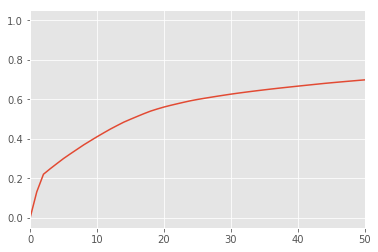

In [136]:
plt.xlim(0,50)
plt.plot(temp_index, temp_percent)

In [137]:
# Use top 20 levels to include 56% information and specify the rest levels as 'Other titles'
round(sum(loan['unique_title'].value_counts()[0:20]) / loan.shape[0], 4)

0.5609

In [138]:
top_20_levels = list(loan['unique_title'].value_counts()[0:20].index)

T_unique_title = []
for each in loan['unique_title']:
    if each in top_20_levels:
        T_unique_title.append(each)
    # Specify the rest levels as 'Other titles'
    elif each not in top_20_levels:
        T_unique_title.append('Other titles')

In [139]:
loan['T_unique_title'] = T_unique_title
print(loan.shape)

# Check if 21 levels (20 Top levels + Other titles) in T_unique_title and cover 56% information 
print(len(loan['T_unique_title'].value_counts()))
print(sum(loan['T_unique_title'].value_counts()[1:])/ loan.shape[0])

(107864, 153)
21
0.5609378476600163


In [140]:
loan = loan.drop(["unique_title", "emp_title"], axis = 1)
print(loan.shape)

(107864, 151)


#### (2-2) Deal with emp_length

In [141]:
print(loan.emp_length.isnull().sum())
print(loan.emp_length.unique())

# I decide to not collapse down the number of levels in emp_length
# It's fine to use 12 levels
print(len(loan.emp_length.unique()))

9428
['10+ years' '5 years' '3 years' '4 years' nan '1 year' '9 years'
 '8 years' '2 years' '< 1 year' '7 years' '6 years']
12


In [142]:
# NA imputation by assigning a NA level
loan.emp_length.fillna('NA_emp_length', inplace = True)

#### (2-3) Deal with revol_util

In [143]:
# revol_util should be a float type feature
print(loan['revol_util'].head())

0    36.9%
1    69.5%
2    61.2%
3    69.7%
4    28.8%
Name: revol_util, dtype: object


In [144]:
# transform revol_util into a float type feature
loan['revol_util'] = loan.revol_util.str.replace('%', '').astype('float').values
print(loan['revol_util'].head())

0    36.9
1    69.5
2    61.2
3    69.7
4    28.8
Name: revol_util, dtype: float64


In [145]:
# NA imputation (median)
print(loan['revol_util'].isnull().sum())
print(np.nanmedian(loan['revol_util']))

149
41.5


In [146]:
loan.revol_util.fillna(np.nanmedian(loan['revol_util']), inplace = True)

In [147]:
# Final check
i = 0
for each in loan:
    if loan[each].dtype == 'object':
        if loan[each].isnull().sum() != 0:
            print(each, loan[each].isnull().sum(), 'NA values.')
            i += 1
print()
print(i, 'categorical type of features contain NA values.')


0 categorical type of features contain NA values.


## 5. Feature transformation

#### 5-1. Datetime type features transformation
1. Summary: Still, there are other datetime type features needed to be deal with. They could be important features after the transformation.
2. Features:
    - issue_d: The month which the loan was funded.
    - earliest_cr_line: The month the borrower's earliest reported credit line was opened. 
3. Transformation
    - issue_d: compare itself with the maximum value (2018-03-01) in itself. (Using the same benchmark day to avoid a biased outcome.)
    - earliest_cr_line: compare itself with the maximum value (2018-03-01) in issue_d. (Using the maximum value in issue_d as a benchmark to compare with earliest_cr_line is reasonable because if the day difference is larger, it might indicate that a loan applicant had a long credit history before, which might further indicate that a loan applicant could fully paid a loan application with a higher probability.)
    
#### 5-2. Features with a wrong data type
#### 5-3. Categorical features with too many levels
#### 5-4. Final check

#### (1) Deal with issue_d

In [148]:
# Three unique values under T_issue_d
print(loan.T_issue_d.unique())
print(min(loan.T_issue_d))
print(max(loan.T_issue_d))

# No NA values in T_issue_d
print(loan.T_issue_d.isnull().sum())

['2018-03-01T00:00:00.000000000' '2018-02-01T00:00:00.000000000'
 '2018-01-01T00:00:00.000000000']
2018-01-01 00:00:00
2018-03-01 00:00:00
0


In [149]:
# Use the maximum value 2018-03-01 as a benchmark
days_since_issue = []
for each in (pd.to_datetime('2018-03-01') - loan.T_issue_d ):
    days_since_issue.append(each.days)

In [150]:
# Make sure the output is correct
set(days_since_issue)

{0, 28, 59}

In [151]:
# Create a new column named days_since_issue in loan
loan['days_since_issue'] = days_since_issue
print(loan.shape)

(107864, 152)


In [152]:
# No clear relationship between days_since_issue & loan_status
loan.groupby(['days_since_issue', 'loan_status']).size()

days_since_issue  loan_status       
0                 Charged Off              31
                  Current               36306
                  Fully Paid             1730
                  In Grace Period         241
                  Late (16-30 days)       130
                  Late (31-120 days)      333
28                Charged Off              75
                  Current               30127
                  Fully Paid             1897
                  In Grace Period         228
                  Late (16-30 days)       111
                  Late (31-120 days)      308
59                Charged Off             159
                  Current               32660
                  Fully Paid             2625
                  In Grace Period         292
                  Late (16-30 days)       149
                  Late (31-120 days)      462
dtype: int64

In [153]:
loan['days_since_issue'].unique()

array([ 0, 28, 59])

In [154]:
level_since_issue = []
for each in loan['days_since_issue']:
    if each == 0:
        level_since_issue.append('0 mth')
    elif each == 28:
        level_since_issue.append('1 mth')
    elif each == 59:
        level_since_issue.append('2 mths')

In [155]:
# Create a new column named level_since_issue in loan
loan['level_since_issue'] = level_since_issue
print(loan.shape)
loan[['days_since_issue', 'level_since_issue']].head(10)

(107864, 153)


,days_since_issue,level_since_issue
0,0,0 mth
1,0,0 mth
2,0,0 mth
3,0,0 mth
4,0,0 mth
5,0,0 mth
6,0,0 mth
7,0,0 mth
8,0,0 mth
9,0,0 mth


#### (2) Deal with earliest_cr_line

In [156]:
loan.earliest_cr_line.head()

0    Jun-2004
1    Oct-2001
2    Aug-2007
3    Aug-2000
4    Aug-2005
Name: earliest_cr_line, dtype: object

In [157]:
print(loan.earliest_cr_line.unique()[0:5])
print(min(loan.earliest_cr_line))
print(max(loan.earliest_cr_line))

# No NA values in earliest_cr_line
print(loan.earliest_cr_line.isnull().sum())

['Jun-2004' 'Oct-2001' 'Aug-2007' 'Aug-2000' 'Aug-2005']
Apr-1963
Sep-2014
0


In [158]:
loan['T_earliest_cr_line'] = pd.to_datetime(loan['earliest_cr_line'])

# Drop earliest_cr_line
print(loan.shape)
loan = loan.drop('earliest_cr_line', axis = 1)
print(loan.shape)

(107864, 154)
(107864, 153)


In [159]:
# Use maximum value 2018-03-01 in T_issue_d as a benchmark
days_between_max_issue_earliest_cr_line = []
for each in (pd.to_datetime('2018-03-01') - loan.T_earliest_cr_line):
    days_between_max_issue_earliest_cr_line.append(each.days)

In [160]:
# Create a new column named days_between_max_issue_earliest_cr_line in loan
loan['days_between_max_issue_earliest_cr_line'] = days_between_max_issue_earliest_cr_line
print(loan.shape)

(107864, 154)


In [161]:
# I decided to create 10 bins
print(max(loan['days_between_max_issue_earliest_cr_line'].unique()))
print(min(loan['days_between_max_issue_earliest_cr_line'].unique()))
print((max(loan['days_between_max_issue_earliest_cr_line'].unique()) - \
     min(loan['days_between_max_issue_earliest_cr_line'].unique())) / 10)

24896
1124
2377.2


In [162]:
# The difference between each bin is 2555 days (7 years) 
level_between_max_issue_earliest_cr_line = []
for each in loan['days_between_max_issue_earliest_cr_line']:
    if each <= 2555:
        level_between_max_issue_earliest_cr_line.append('7 yrs')
    elif (each > 2555) and (each <= 5110):
        level_between_max_issue_earliest_cr_line.append('14 yrs')
    elif (each > 5110) and (each <= 7665):
        level_between_max_issue_earliest_cr_line.append('21 yrs')
    elif (each > 7665) and (each <= 10220):
        level_between_max_issue_earliest_cr_line.append('28 yrs')   
    elif (each > 10220) and (each <= 12775):
        level_between_max_issue_earliest_cr_line.append('35 yrs')
    elif (each > 12775) and (each <= 15330):
        level_between_max_issue_earliest_cr_line.append('42 yrs')   
    elif (each > 15330) and (each <= 17885):
        level_between_max_issue_earliest_cr_line.append('49 yrs')
    elif (each > 17885) and (each <= 20440):
        level_between_max_issue_earliest_cr_line.append('56 yrs')
    elif (each > 20440) and (each <= 22995):
        level_between_max_issue_earliest_cr_line.append('63 yrs')
    elif (each > 22995) and (each <= 25550):
        level_between_max_issue_earliest_cr_line.append('70 yrs')

In [163]:
set(level_between_max_issue_earliest_cr_line)

{'14 yrs',
 '21 yrs',
 '28 yrs',
 '35 yrs',
 '42 yrs',
 '49 yrs',
 '56 yrs',
 '63 yrs',
 '7 yrs',
 '70 yrs'}

In [164]:
# Create a new column named level_between_max_issue_earliest_cr_line in loan
loan['level_between_max_issue_earliest_cr_line'] = level_between_max_issue_earliest_cr_line
print(loan.shape)
loan[['days_between_max_issue_earliest_cr_line', 'level_between_max_issue_earliest_cr_line']].head(10)

(107864, 155)


,days_between_max_issue_earliest_cr_line,level_between_max_issue_earliest_cr_line
0,5021,14 yrs
1,5995,21 yrs
2,3865,14 yrs
3,6421,21 yrs
4,4595,14 yrs
5,2800,14 yrs
6,5660,21 yrs
7,6268,21 yrs
8,7790,28 yrs
9,8917,28 yrs


#### 5-2. Features with a wrong data type 
1. Features:
    - int_rate: Iterest rate on the loan.

In [165]:
loan['int_rate'] = loan.int_rate.str.replace('%', '').astype('float').values

In [166]:
print(loan['int_rate'].head())

0     7.34
1     7.96
2    10.90
3     5.31
4    12.61
Name: int_rate, dtype: float64


#### 5-3. Categorical features with too many levels
1. Features:
    - addr_state: The state provided by the borrower in the loan application.
2. Transformation:
    - addr_state: Assign each state by west or east coast and drop zip_code column.

In [167]:
for each in loan:
    if loan[each].dtype == 'object':
        if len(loan[each].unique()) >= 10:
            print(each)
            print(loan[each].unique()[0:5])
            print(len(loan[each].unique()))
            print()

sub_grade
['A4' 'A5' 'B4' 'A1' 'C1']
35

emp_length
['10+ years' '5 years' '3 years' '4 years' 'NA_emp_length']
12

purpose
['debt_consolidation' 'other' 'credit_card' 'home_improvement'
 'major_purchase']
13

title
['Debt consolidation' 'Other' 'Credit card refinancing' 'Home improvement'
 'Major purchase']
12

zip_code
['606xx' '302xx' '932xx' '190xx' '201xx']
878

addr_state
['IL' 'GA' 'CA' 'PA' 'VA']
50

level_between_max_issue_sec_earliest_cr_line
['NA yrs' '35 yrs' '7 yrs' '14 yrs' '21 yrs']
11

level_since_last_credit_pull
['Negative 4 mths' 'Negative 1 mth' '0 mth' 'Negative 3 mths'
 'Negative 2 mths']
10

T_unique_title
['president' 'manager' 'Other titles' 'owner' 'consultant']
21

level_between_max_issue_earliest_cr_line
['14 yrs' '21 yrs' '28 yrs' '35 yrs' '7 yrs']
10



In [168]:
len(loan.addr_state.unique())

50

In [169]:
us_state_map = {'west': ['WA', 'OR', 'ID', 'MT', 'WY', 
                         'CA', 'NV', 'UT', 'CO',
                         'AK', 'HI'],
                'midwest': ['ND', 'SD', 'NE', 'KS', 'MN',
                            'IA', 'MO', 'WI', 'IL', 'MI',
                            'IN', 'OH'],
                'southwest': ['AZ', 'NM', 'OK', 'TX'],
                'southeast': ['KY', 'WV', 'DC', 'VA', 'AR',
                              'LA', 'TN', 'NC', 'MS', 'AL',
                              'GA', 'SC', 'FL'],
                'northeast': ['PA', 'MD', 'NY', 'VT', 'ME',
                              'NH', 'MA', 'RI', 'CT', 'NJ',
                              'DE']
               }

In [170]:
for key, value in us_state_map.items():
    print(key, value)

west ['WA', 'OR', 'ID', 'MT', 'WY', 'CA', 'NV', 'UT', 'CO', 'AK', 'HI']
midwest ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']
southwest ['AZ', 'NM', 'OK', 'TX']
southeast ['KY', 'WV', 'DC', 'VA', 'AR', 'LA', 'TN', 'NC', 'MS', 'AL', 'GA', 'SC', 'FL']
northeast ['PA', 'MD', 'NY', 'VT', 'ME', 'NH', 'MA', 'RI', 'CT', 'NJ', 'DE']


In [171]:
group_state = []
for each in loan.addr_state:
    for key, value in us_state_map.items():
        state_key = key
        state_values = value 
        if each in state_values:
            group_state.append(key)

In [172]:
# Make sure the length of the output
len(group_state)

107864

In [173]:
loan['group_state'] = group_state
loan = loan.drop(['addr_state','zip_code'], axis = 1)
print(loan.shape)

(107864, 154)


In [174]:
# Make sure the final output
loan['group_state'].unique()

array(['midwest', 'southeast', 'west', 'northeast', 'southwest'],
      dtype=object)

#### 5-4. Final check

In [175]:
# Final check I: NA values
# These are variables forgot to drop after complete the transformation
drop_col = []
for each in loan:
    if loan[each].isnull().sum() != 0:
        print(each)
        drop_col.append(each)

T_payment_plan_start_date
T_hardship_start_date
T_hardship_end_date
T_settlement_date
T_sec_app_earliest_cr_line
T_last_pymnt_d
T_next_pymnt_d
T_last_credit_pull_d


In [176]:
loan = loan.drop(drop_col, axis = 1)
print(loan.shape)

(107864, 146)


In [177]:
# Final check II: features with only one unique value among all records (no prediction power)
drop_col = []
for each in loan:
    if len(loan[each].unique()) == 1:
        print(each)
        drop_col.append(each)

pymnt_plan
policy_code
num_tl_120dpd_2m


In [178]:
loan = loan.drop(drop_col, axis = 1)
print(loan.shape)

(107864, 143)


In [179]:
# Final check III: manually scan the data type & columns forgot to drop
for each in loan:
    print(loan[each].head())
    print('-------------------------------')

0     7000.0
1     5000.0
2    17000.0
3    20000.0
4    25000.0
Name: loan_amnt, dtype: float64
-------------------------------
0     7000.0
1     5000.0
2    17000.0
3    20000.0
4    25000.0
Name: funded_amnt, dtype: float64
-------------------------------
0     7000.0
1     5000.0
2    17000.0
3    20000.0
4    25000.0
Name: funded_amnt_inv, dtype: float64
-------------------------------
0     36 months
1     36 months
2     36 months
3     36 months
4     60 months
Name: term, dtype: object
-------------------------------
0     7.34
1     7.96
2    10.90
3     5.31
4    12.61
Name: int_rate, dtype: float64
-------------------------------
0    217.23
1    156.59
2    555.76
3    602.21
4    563.85
Name: installment, dtype: float64
-------------------------------
0    A
1    A
2    B
3    A
4    C
Name: grade, dtype: object
-------------------------------
0    A4
1    A5
2    B4
3    A1
4    C1
Name: sub_grade, dtype: object
-------------------------------
0    10+ years
1    10+ ye

In [180]:
drop_col = ['issue_d', 'T_issue_d', 'T_earliest_cr_line']
loan = loan.drop(drop_col, axis = 1)
print(loan.shape)

(107864, 140)


## 6. Outliers imputation
- reference (three ways of outlier detectation): http://colingorrie.github.io/outlier-detection.html

In [181]:
# function of detecting outliers
def outliers_iqr(input_data):
    quartile_1, quartile_3 = np.percentile(input_data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.array(np.where((input_data > upper_bound) | (input_data < lower_bound))).flatten()

In [182]:
# function of detecting outliers
def outliers_iqr_I(input_data):
    quartile_1, quartile_3 = np.percentile(input_data, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.array(np.where(input_data > upper_bound)).flatten(),\
np.array(np.where(input_data < lower_bound)).flatten(), upper_bound, lower_bound

In [183]:
# collect names of numerical type of features
num_col = []
for each in loan:
    if loan[each].dtype != 'object':
        num_col.append(each)
print(len(num_col))

109


In [184]:
# notice that we must remove 'loan_status_binary' from the num_col
# otherwise, we will do outlier imputation on this column too
num_col.remove('loan_status_binary')

In [185]:
# collect names of numerical type of features containing outliers
outlier_num_col = []
for each in num_col:
    if len(outliers_iqr(loan[each])) != 0:
        outlier_num_col.append(each)

In [186]:
# 101 numerical type of features containing outliers
len(outlier_num_col)

101

In [187]:
# outlier imputation (capping)
for each in outlier_num_col:
    loan[each][outliers_iqr_I(loan[each])[0]] = outliers_iqr_I(loan[each])[2]
    loan[each][outliers_iqr_I(loan[each])[1]] = outliers_iqr_I(loan[each])[3]

/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/wuchenhong/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [188]:
# make sure finish outlier imputation 
for each in outlier_num_col:
    if len(outliers_iqr_I(loan[each])[0]) != 0:
        print(each)

## 7. Feature selection by feature significance
#### 7.1 Numerical type of features: using t-test
- t-test documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html

#### 7.2 Categorical type of features: using chi-square test
- chi-square test documentation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html

### 7.1 Numerical type of features: using t-test

In [189]:
# Notice: after NA imputation, 42 numerical features only contain one unique value
# These numerical features should be dropped when performing a t-test & calculating correlation
i = 0
drop_col = []

for each in loan.columns:
    if loan[each].dtype != 'object':
        if len(loan[each].unique()) == 1:
            drop_col.append(each)
            i += 1
i

42

In [190]:
loan = loan.drop(drop_col, axis = 1)
print(loan.shape)

(107864, 98)


In [191]:
cate_col = []
num_col = []
for each in loan:
    if loan[each].dtype == 'object':
        cate_col.append(each)
    else: 
        num_col.append(each)

In [192]:
# Make sure the for loop selected every column
len(cate_col) + len(num_col) == loan.shape[1]

True

In [193]:
# Function of performing a two-sided t-test (unequal variance between two groups)
def num_feature_significance(col_name):
    p_value = stats.ttest_ind(loan[loan['loan_status_binary'] == 0][col_name],
               loan[loan['loan_status_binary'] == 1][col_name],
                              equal_var=False,
                              nan_policy='omit')[1]
    return p_value

In [194]:
# Perform the t-test for each numerical feature
all_p_value = []
for each in num_col:
    all_p_value.append(num_feature_significance(each))

In [195]:
i = 0
j = 0
for col_name, p_value in list(zip(num_col, all_p_value)):
    if p_value < 0.05:
        i += 1

for col_name, p_value in list(zip(num_col, all_p_value)):
    if p_value < 0.01:
        j += 1

In [196]:
print('Originally I have',len(num_col),'numerical type of features.')
print(i,'numerical type of features passed 0.05 threshold.')
print(j,'numerical type of features passed 0.01 threshold.')
print(len(num_col) - i,'numerical type of features not passed 0.05 threshold.')

Originally I have 67 numerical type of features.
61 numerical type of features passed 0.05 threshold.
58 numerical type of features passed 0.01 threshold.
6 numerical type of features not passed 0.05 threshold.


In [197]:
# Find the top 10 numerical type of features by sorting the p-values
np.argsort(all_p_value)[1:11]

array([63, 16, 14, 15,  3,  7, 60, 37, 45, 31])

In [199]:
tem_col_name = []
for each in [63, 16, 14, 15,  3,  7, 60, 37, 45, 31]:
    tem_col_name.append(num_col[each])

print(len(tem_col_name))
print(tem_col_name)

10
['numeric_diff_last_issue_d', 'total_rec_prncp', 'total_pymnt', 'total_pymnt_inv', 'int_rate', 'inq_last_6mths', 'total_bc_limit', 'bc_open_to_buy', 'mths_since_recent_inq', 'total_rev_hi_lim']


#### 7.1.1 Distribution visualization using top 10 numerical type of features

In [200]:
# Function of visualization
def num_feature_distribution_plot(col_name):
    plt.figure(figsize = (10, 8))

    # KDE plot of loan_status_binary is 0 
    sns.kdeplot(loan.loc[loan['loan_status_binary'] == 0, col_name], label = 'target == 0')

    # KDE plot of loan_status_binary is 1 (either Current or Fully Paid)
    sns.kdeplot(loan.loc[loan['loan_status_binary'] == 1, col_name], label = 'target == 1')

    # Labeling of plot
    plt.xlabel(col_name)
    plt.title('Distribution of '+ col_name)

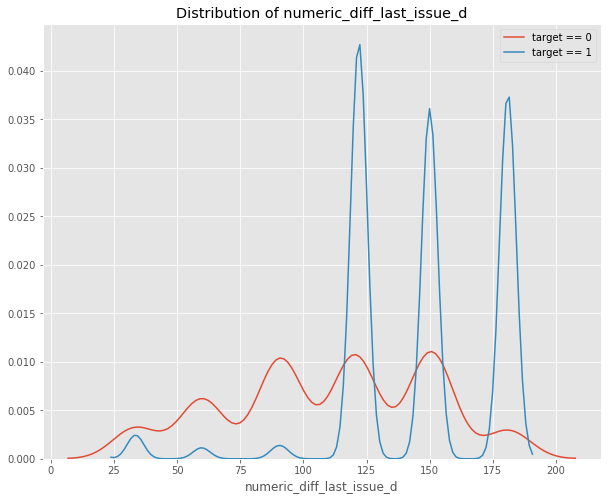

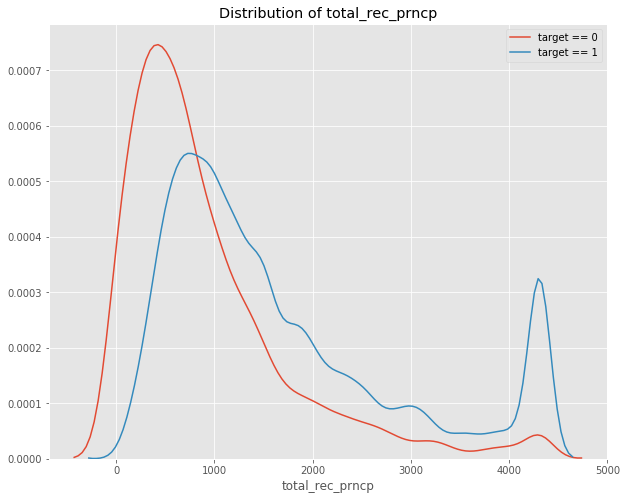

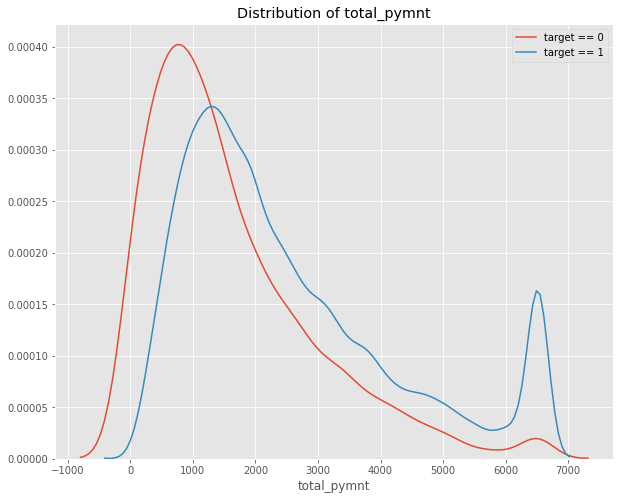

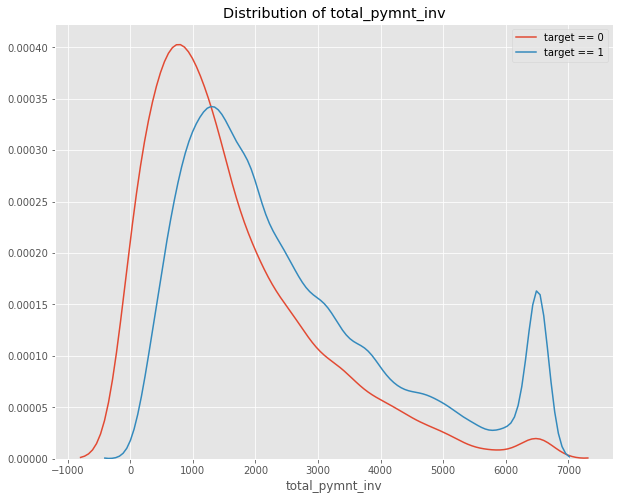

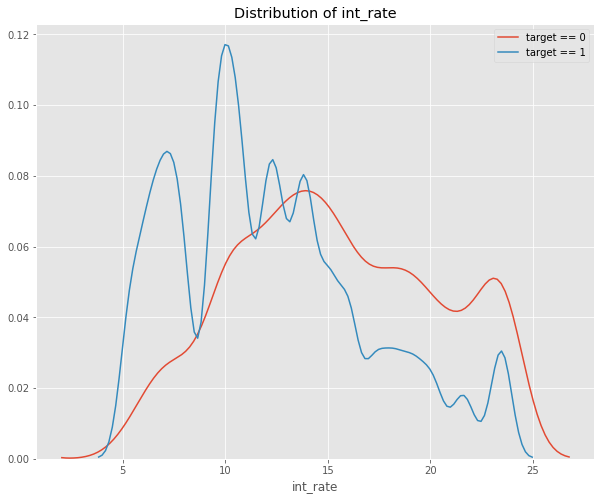

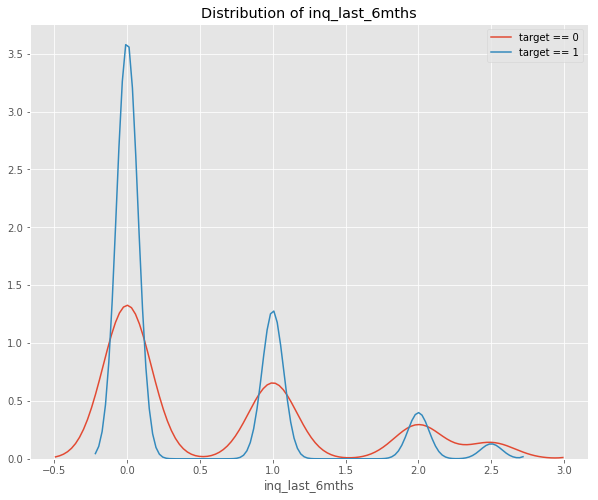

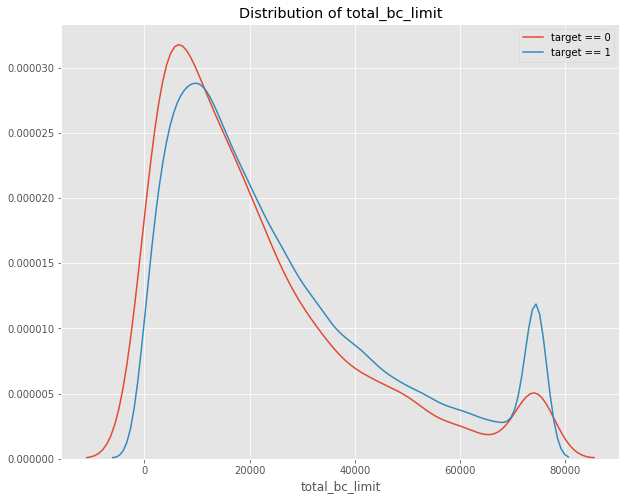

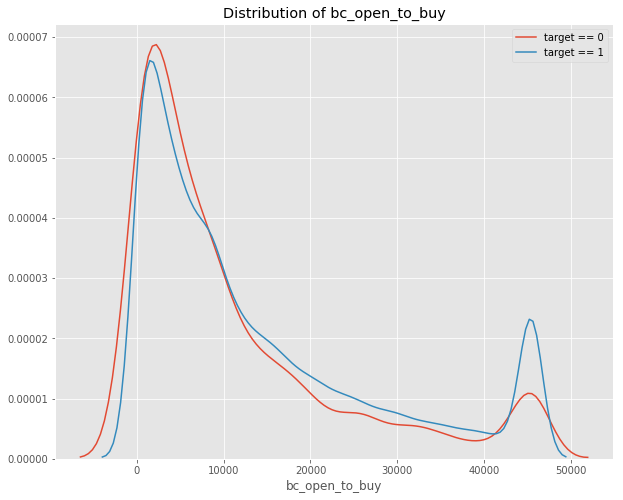

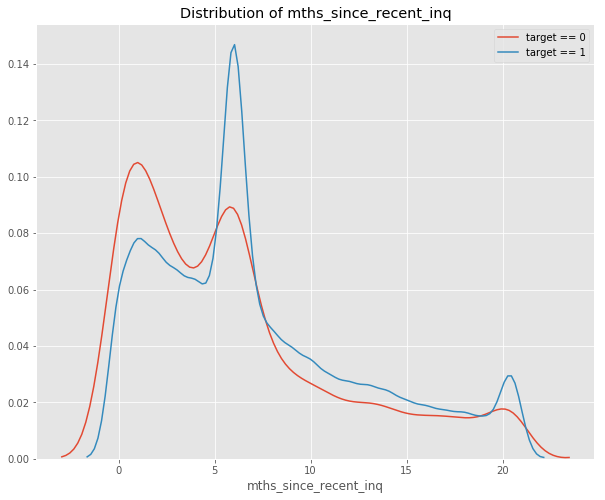

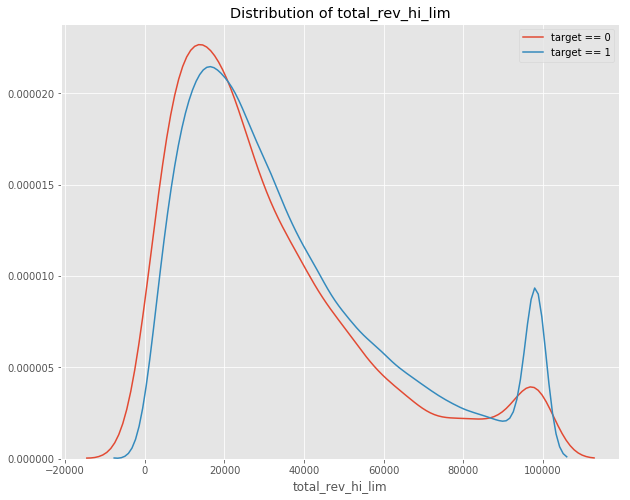

In [201]:
for each in tem_col_name:
    num_feature_distribution_plot(each)

#### 7.1.2 Heatmap of correlations (top 10 numerical type of features VS loan_status_binary)
- sns.heatmap documentation: https://seaborn.pydata.org/generated/seaborn.heatmap.html

In [202]:
tem_col_name.append('loan_status_binary')

In [203]:
top_ten_num_col_corr = loan[tem_col_name].corr()
top_ten_num_col_corr

,numeric_diff_last_issue_d,total_rec_prncp,total_pymnt,total_pymnt_inv,int_rate,inq_last_6mths,total_bc_limit,bc_open_to_buy,mths_since_recent_inq,total_rev_hi_lim,loan_status_binary
numeric_diff_last_issue_d,1.000000,-0.086353,-0.064826,-0.064915,-0.046247,-0.025860,0.011194,-0.000584,0.023090,0.004809,0.169058
total_rec_prncp,-0.086353,1.000000,0.945494,0.945418,-0.182788,-0.006853,0.290287,0.215567,-0.006592,0.284785,0.094430
total_pymnt,-0.064826,0.945494,1.000000,0.999996,0.042874,0.013059,0.255671,0.151916,-0.024254,0.257092,0.080468
total_pymnt_inv,-0.064915,0.945418,0.999996,1.000000,0.042999,0.013020,0.255723,0.151967,-0.024226,0.257138,0.080462
int_rate,-0.046247,-0.182788,0.042874,0.042999,1.000000,0.134553,-0.295308,-0.396046,-0.089718,-0.273112,-0.101182
inq_last_6mths,-0.025860,-0.006853,0.013059,0.013020,0.134553,1.000000,0.012721,0.044062,-0.547572,0.039151,-0.047051
total_bc_limit,0.011194,0.290287,0.255671,0.255723,-0.295308,0.012721,1.000000,0.841153,-0.000112,0.903302,0.031936
bc_open_to_buy,-0.000584,0.215567,0.151916,0.151967,-0.396046,0.044062,0.841153,1.000000,-0.037766,0.754393,0.028510
mths_since_recent_inq,0.023090,-0.006592,-0.024254,-0.024226,-0.089718,-0.547572,-0.000112,-0.037766,1.000000,-0.020244,0.031012
total_rev_hi_lim,0.004809,0.284785,0.257092,0.257138,-0.273112,0.039151,0.903302,0.754393,-0.020244,1.000000,0.028413


Text(0.5,1,'Correlation Heatmap')

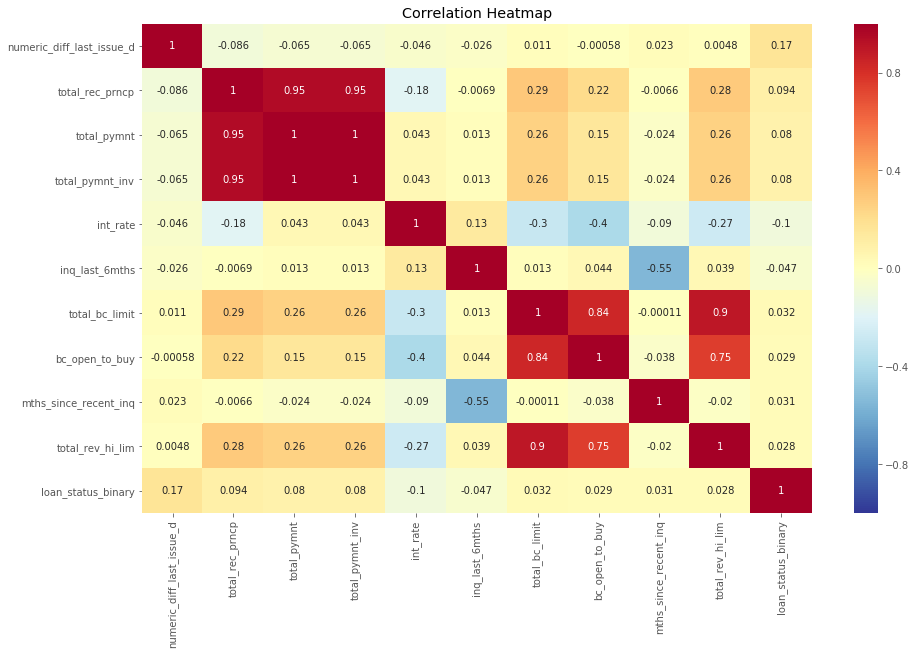

In [204]:
# Some multicollinearity between some features
plt.figure(figsize = (15, 9))

sns.heatmap(top_ten_num_col_corr, cmap = plt.cm.RdYlBu_r, vmin = -1, annot = True, vmax = 1)
plt.title('Correlation Heatmap')

In [205]:
print(len(num_col))
print(len(all_p_value))

67
67


In [206]:
# collect rank in correlation and feature significance
num_feat_selection = pd.DataFrame({'name':num_col,
                                   'p_value':all_p_value,
                                   'correlation':loan[num_col].corr()['loan_status_binary'].values})

In [207]:
num_feat_selection[num_feat_selection['name'] == 'loan_status_binary']

,name,p_value,correlation
62,loan_status_binary,0.0,1.0


In [208]:
# attain top 10 numerical features by sorting out top 10 smallest p values
num_feat_selection.iloc[np.argsort(all_p_value)[1:11]]

,name,p_value,correlation
63,numeric_diff_last_issue_d,2.654631e-314,0.169058
16,total_rec_prncp,7.189327e-297,0.094430
14,total_pymnt,6.609935e-202,0.080468
15,total_pymnt_inv,6.909583e-202,0.080462
3,int_rate,3.000183e-189,-0.101182
7,inq_last_6mths,5.571328e-38,-0.047051
60,total_bc_limit,1.785616e-28,0.031936
37,bc_open_to_buy,9.715383e-24,0.028510
45,mths_since_recent_inq,1.744492e-23,0.031012
31,total_rev_hi_lim,4.593647e-22,0.028413


In [209]:
# attain top 10 numerical features by sorting out top 10 absolute correlations
num_feat_selection.iloc[np.argsort(abs(loan[num_col].corr()['loan_status_binary'].values))[::-1][1:11]]

,name,p_value,correlation
63,numeric_diff_last_issue_d,2.654631e-314,0.169058
3,int_rate,3.000183e-189,-0.101182
16,total_rec_prncp,7.189327e-297,0.094430
14,total_pymnt,6.609935e-202,0.080468
15,total_pymnt_inv,6.909583e-202,0.080462
7,inq_last_6mths,5.571328e-38,-0.047051
60,total_bc_limit,1.785616e-28,0.031936
45,mths_since_recent_inq,1.744492e-23,0.031012
34,inq_last_12m,2.696834e-19,-0.029966
37,bc_open_to_buy,9.715383e-24,0.028510


In [210]:
loan[num_col].corr()['loan_status_binary'].\
                   iloc[np.argsort(abs(loan[num_col].corr()['loan_status_binary'].values))[::-1][0:10]].index

Index(['loan_status_binary', 'numeric_diff_last_issue_d', 'int_rate',
       'total_rec_prncp', 'total_pymnt', 'total_pymnt_inv', 'inq_last_6mths',
       'total_bc_limit', 'mths_since_recent_inq', 'inq_last_12m'],
      dtype='object')

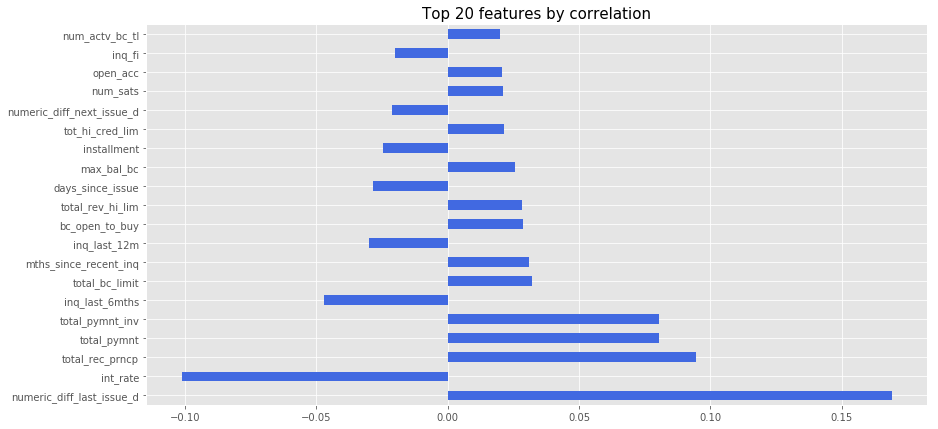

In [211]:
# bar chart plot of coefficients of features

# set plot size
fig = plt.figure(figsize=(14,7))

# bar chart
ax = loan[num_col].corr()['loan_status_binary'].\
iloc[np.argsort(abs(loan[num_col].corr()['loan_status_binary'].values))[::-1][1:21]].plot.barh(color = 'royalblue')

# y ticks, y lables, and title name
t = np.arange(20)
ax.set_yticks(t)
ax.set_yticklabels(loan[num_col].corr()['loan_status_binary'].\
                   iloc[np.argsort(abs(loan[num_col].corr()['loan_status_binary'].values))[::-1][1:21]].index)
plt.title('Top 20 features by correlation',fontsize=15)

plt.show()

### 7.2 Categorical type of features: using chi-square test

In [212]:
cate_col[0:5]

['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership']

In [213]:
def cate_feature_significance(col_name):
    # collect row sum
    row_sum_1 = sum(loan[loan.loan_status_binary == 0][col_name].value_counts())
    row_sum_2 = sum(loan[loan.loan_status_binary == 1][col_name].value_counts())
    
    total_sum = row_sum_1 + row_sum_2
    
    # collect column sum by each index
    index_name = []
    for name in loan[col_name].unique():
        index_name.append(name)
    
    col_sum = []    
    for name in index_name:
        col_sum.append(loan[loan.loan_status_binary == 0][col_name].value_counts()[name] + \
                       loan[loan.loan_status_binary == 1][col_name].value_counts()[name])
        
    if len(col_sum) == len(index_name):
    
        # collect original values
        original_values = []
        for each in index_name:
            original_values.append(loan[loan.loan_status_binary == 0][col_name].value_counts()[each])
        for each in index_name:
            original_values.append(loan[loan.loan_status_binary == 1][col_name].value_counts()[each])
            
        # collect expected values
        expected_values = []
        for i in range(0, len(index_name)):
            expected_values.append((col_sum[i]*row_sum_1) / total_sum)
            
        for i in range(0, len(index_name)):
            expected_values.append((col_sum[i]*row_sum_2) / total_sum)
        
        # perform chi-square test
        degree_of_freedom = len(index_name) - 1
        p_value = stats.chisquare(original_values, f_exp = expected_values, ddof = degree_of_freedom)[1]
        chi_square_statistic = stats.chisquare(original_values, f_exp = expected_values, ddof = degree_of_freedom)[0]
        return p_value, chi_square_statistic, original_values, expected_values
        
    elif len(col_sum) != len(index_name):
        print('error occurred', col_name)

In [214]:
def cate_feature_significance_I(col_name):
    
    loan_status_binary_0 = loan[loan.loan_status_binary == 0][col_name].value_counts()
    loan_status_binary_1 = loan[loan.loan_status_binary == 1][col_name].value_counts()
    
    # collect row sum
    row_sum_1 = sum(loan_status_binary_0)
    row_sum_2 = sum(loan_status_binary_1)
    
    total_sum = row_sum_1 + row_sum_2
    
    # collect column sum by each index
    index_name = [name for name in loan[col_name].unique()]
    
    col_sum = []
    for name in index_name:
        if name in loan_status_binary_0.index:
            col_0 = loan_status_binary_0[name]
        elif name not in loan_status_binary_0.index:
            col_0 = 0
        if name in loan_status_binary_1.index:
            col_1 = loan_status_binary_1[name]
        elif name not in loan_status_binary_1.index:
            col_1 = 0
        col_sum.append(col_0 + col_1)
        
    if len(col_sum) == len(index_name):
        # collect original values
        original_values = []

        for name in index_name:
            if name in loan_status_binary_0.index:
                col_0 = loan_status_binary_0[name]
            elif name not in loan_status_binary_0.index:
                col_0 = 0
            original_values.append(col_0)

        for name in index_name:        
            if name in loan_status_binary_1.index:
                col_1 = loan_status_binary_1[name]
            elif name not in loan_status_binary_1.index:
                col_1 = 0
            original_values.append(col_1)
        
        # collect expected values
        expected_values = []
        for i in range(0, len(index_name)):
            expected_values.append((col_sum[i]*row_sum_1) / total_sum)

        for i in range(0, len(index_name)):
            expected_values.append((col_sum[i]*row_sum_2) / total_sum)

        # perform chi-square test
        degree_of_freedom = len(index_name) - 1
        p_value = stats.chisquare(original_values, f_exp = expected_values, ddof = degree_of_freedom)[1]
        chi_square_statistic = stats.chisquare(original_values, f_exp = expected_values, ddof = degree_of_freedom)[0]
        return p_value, chi_square_statistic, original_values, expected_values
        
    elif len(col_sum) != len(index_name):
        print('error occurred', col_name)

#### manually test few categorical features to check whether the outputs from cate_feature_significance() is correct

#### (1) Test on 'term'

In [215]:
loan.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [216]:
# original cell values
print(loan[loan.loan_status_binary == 0]['term'].value_counts())
print()
print(loan[loan.loan_status_binary == 1]['term'].value_counts())

 36 months    1576
 60 months     943
Name: term, dtype: int64

 36 months    73836
 60 months    31509
Name: term, dtype: int64


In [217]:
# row sum
print(sum(loan[loan.loan_status_binary == 0]['term'].value_counts()))
print(sum(loan[loan.loan_status_binary == 1]['term'].value_counts()))

2519
105345


In [218]:
# column sum
print(loan[loan.loan_status_binary == 0]['term'].value_counts()[0] + \
      loan[loan.loan_status_binary == 1]['term'].value_counts()[0])

print(loan[loan.loan_status_binary == 0]['term'].value_counts()[1] + \
      loan[loan.loan_status_binary == 1]['term'].value_counts()[1])

75412
32452


In [219]:
# total sum
sum(loan[loan.loan_status_binary == 0]['term'].value_counts()) + \
sum(loan[loan.loan_status_binary == 1]['term'].value_counts())

107864

In [220]:
# manual results
# compare original values, expected values, chi-square test statistic, and p-value
a = [1576, 943, 73836, 31509]
b = [75412*2519/107864, 32452*2519/107864, 75412*105345/107864, 32452*105345/107864]
b

[1761.1327968552994, 757.8672031447007, 73650.8672031447, 31694.132796855298]

In [221]:
stats.chisquare(a,b, len(loan.term.unique()) - 1)

Power_divergenceResult(statistic=66.23267075242558, pvalue=4.147231564302271e-15)

In [222]:
# function results
start_time = time.time()
print(cate_feature_significance_I('term'))
print('execution time:',time.time() - start_time)

(4.147231564302271e-15, 66.23267075242558, [1576, 943, 73836, 31509], [1761.1327968552994, 757.8672031447007, 73650.8672031447, 31694.132796855298])
execution time: 0.1149449348449707


#### (2) Test on 'grade'

In [223]:
loan.grade.unique()

array(['A', 'B', 'C', 'D', 'G', 'E', 'F'], dtype=object)

In [224]:
# original cell values
print(loan[loan.loan_status_binary == 0]['grade'].value_counts())
print()
print(loan[loan.loan_status_binary == 1]['grade'].value_counts())

C    789
D    687
B    517
E    241
A    218
F     58
G      9
Name: grade, dtype: int64

B    31965
C    27958
A    26551
D    14690
E     3450
F      624
G      107
Name: grade, dtype: int64


In [225]:
# row sum
print(sum(loan[loan.loan_status_binary == 0]['grade'].value_counts()))
print(sum(loan[loan.loan_status_binary == 1]['grade'].value_counts()))

2519
105345


In [226]:
# column sum
print(loan[loan.loan_status_binary == 0]['grade'].value_counts()[0] + \
      loan[loan.loan_status_binary == 1]['grade'].value_counts()[0])

print(loan[loan.loan_status_binary == 0]['grade'].value_counts()[1] + \
      loan[loan.loan_status_binary == 1]['grade'].value_counts()[1])

32754
28645


In [227]:
# total sum
sum(loan[loan.loan_status_binary == 0]['grade'].value_counts()) + \
sum(loan[loan.loan_status_binary == 1]['grade'].value_counts())

107864

In [228]:
# manual results
# compare original values, expected values, chi-square test statistic, and p-value
a = [218, 517, 789, 687, 9, 241, 58, 26551, 31965, 27958, 14690, 107, 3450, 624]

b = [26769*2519/107864, 32482*2519/107864, 28747*2519/107864, 15377*2519/107864, 116*2519/107864, 3691*2519/107864, 682*2519/107864,
     26769*105345/107864, 32482*105345/107864, 28747*105345/107864, 15377*105345/107864, 116*105345/107864, 3691*105345/107864, 682*105345/107864]

In [229]:
b

[625.1493640139435,
 758.5678076095825,
 671.3425517318104,
 359.1064952161982,
 2.7090039308759177,
 86.19770266261217,
 15.927074834977379,
 26143.850635986055,
 31723.432192390417,
 28075.65744826819,
 15017.893504783802,
 113.29099606912408,
 3604.8022973373877,
 666.0729251650226]

In [230]:
stats.chisquare(a,b, len(loan.grade.unique()) - 1)

Power_divergenceResult(statistic=1091.3564265029693, pvalue=2.1763013116137147e-231)

In [231]:
# function results 
start_time = time.time()
print(cate_feature_significance_I('grade'))
print('execution time:',time.time() - start_time)

(2.1763013116137147e-231, 1091.3564265029693, [218, 517, 789, 687, 9, 241, 58, 26551, 31965, 27958, 14690, 107, 3450, 624], [625.1493640139435, 758.5678076095825, 671.3425517318104, 359.1064952161982, 2.7090039308759177, 86.19770266261217, 15.927074834977379, 26143.850635986055, 31723.432192390417, 28075.65744826819, 15017.893504783802, 113.29099606912408, 3604.8022973373877, 666.0729251650226])
execution time: 0.11847186088562012


In [232]:
cate_feat_all_p = []
for each in cate_col:
    cate_feat_all_p.append(cate_feature_significance_I(each)[0])

In [233]:
len(cate_feat_all_p)

31

In [234]:
i = 0
j = 0
for p_value in cate_feat_all_p:
    if p_value < 0.05:
        i += 1
for p_value in cate_feat_all_p:
    if p_value < 0.01:
        j += 1

In [235]:
print('Originally I have',len(cate_col),'categorical type of features.')
print(i,'categorical type of features passed 0.05 threshold.')
print(j,'categorical type of features passed 0.01 threshold.')
print(len(cate_col) - i,'categorical type of features not passed 0.05 threshold.')

Originally I have 31 categorical type of features.
30 categorical type of features passed 0.05 threshold.
30 categorical type of features passed 0.01 threshold.
1 categorical type of features not passed 0.05 threshold.


In [236]:
pd.DataFrame({'name':cate_col,
             'p_value': cate_feat_all_p})

,name,p_value
0,term,4.147232e-15
1,grade,2.176301e-231
2,sub_grade,2.679901e-233
3,emp_length,7.124256e-07
4,home_ownership,1.043690e-13
5,verification_status,5.674982e-39
6,loan_status,0.000000e+00
7,purpose,3.993923e-33
8,title,1.824630e-32
9,initial_list_status,1.483378e-08


#### 7.2.1 Distribution visualization using top 10 categorical type of features

In [237]:
# Find the top 10 categorical type of features by sorting the p-values
np.argsort(cate_feat_all_p)[1:11]

array([24,  2,  1, 22, 17, 18,  5,  7,  8, 25])

In [240]:
tem_col_name = []
for each in [24,  2,  1, 22, 17, 18,  5,  7,  8, 25]:
    tem_col_name.append(cate_col[each])

print(len(tem_col_name))
print(tem_col_name)

10
['level_diff_last_issue_d', 'sub_grade', 'grade', 'level_between_issue_settlement_date', 'debt_settlement_flag', 'settlement_status', 'verification_status', 'purpose', 'title', 'level_diff_next_issue_d']


In [241]:
def cate_feature_distribution_plot(col_name):
    
    loan_status_binary_0 = loan[loan.loan_status_binary == 0][col_name].value_counts()
    loan_status_binary_1 = loan[loan.loan_status_binary == 1][col_name].value_counts()
    
    index_name = [name for name in loan[col_name].unique()]
    index_name = sorted(index_name)
    value_status_0 = []
    for name in index_name:
        if name in loan_status_binary_0.index:
            tem_value = loan_status_binary_0[name]
        elif name not in loan_status_binary_0.index:
            tem_value = 0
            
        value_status_0.append(tem_value)
        
    value_status_1 = []    
    for name in index_name:
        if name in loan_status_binary_1.index:
            tem_value = loan_status_binary_1[name]
        elif name not in loan_status_binary_1.index:
            tem_value = 0
            
        value_status_1.append(tem_value)
        
    fig = plt.figure(figsize=(14,7))    
    ind = np.arange(len(index_name)) 
    p1 = plt.bar(ind, value_status_0, color='r', alpha = 0.4)
    p2 = plt.bar(ind, value_status_1, color='b', alpha = 0.4)
    
    plt.title('Distribution of ' + col_name)
    plt.xticks(ind, index_name, rotation='vertical')
    plt.legend((p1[0], p2[0]), ('loan status: 0', 'loan status: 1'))
    #return value_status_0, value_status_1

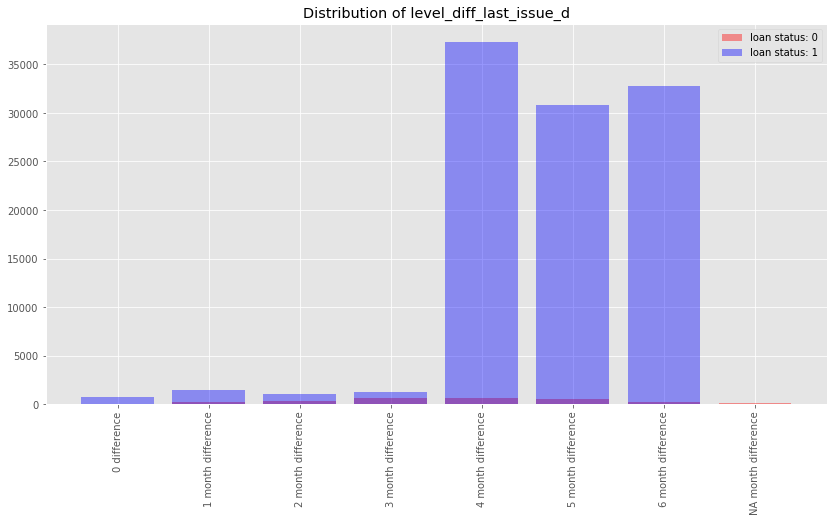

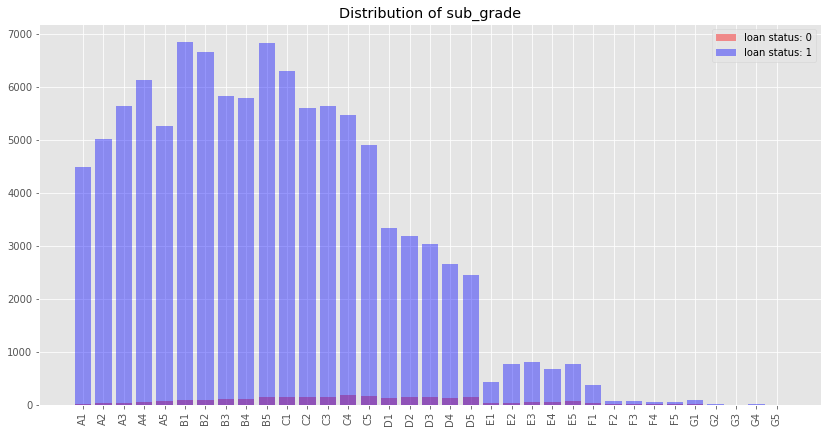

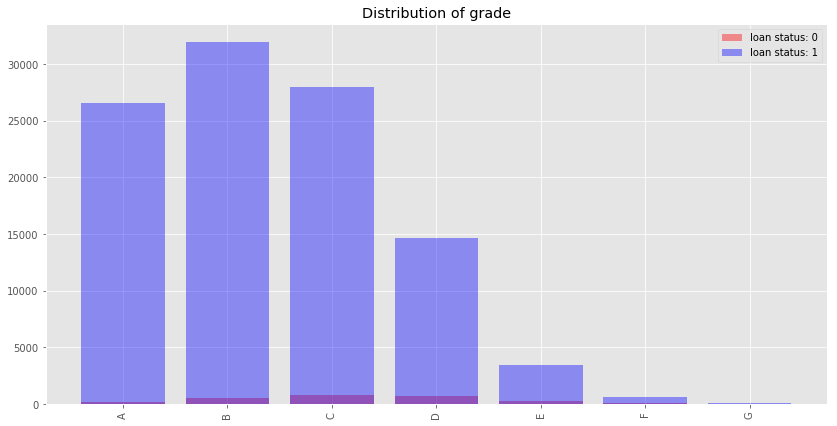

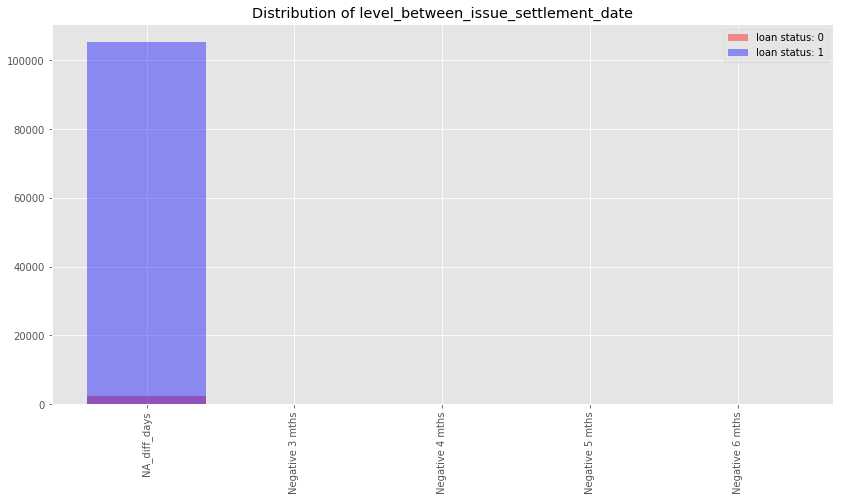

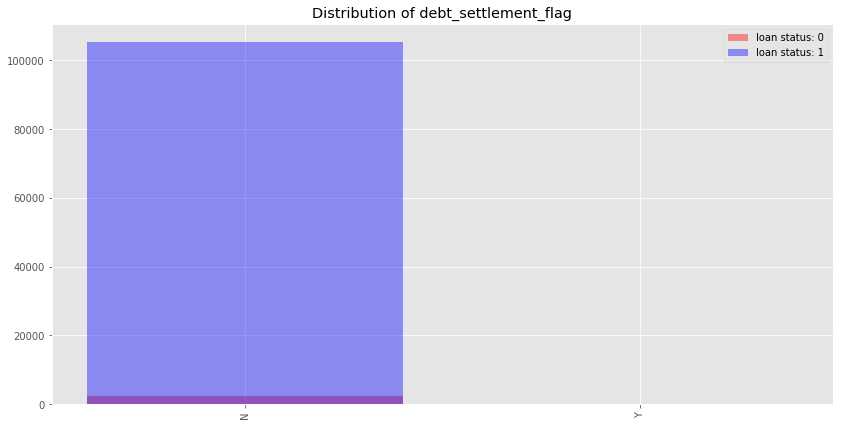

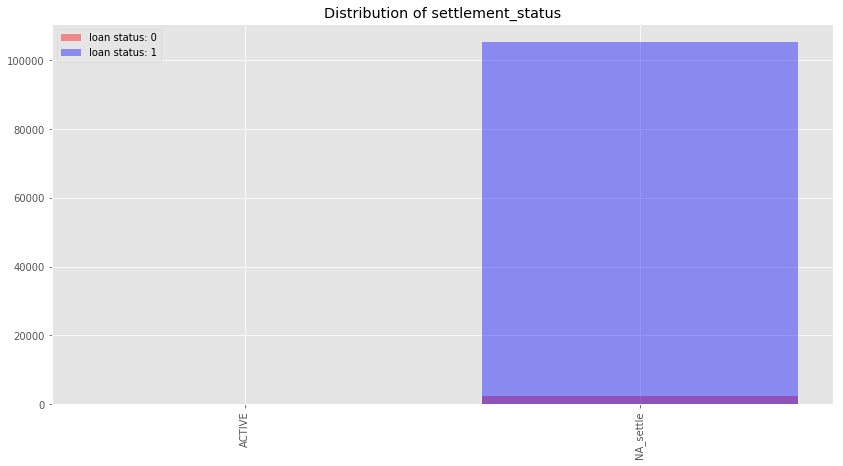

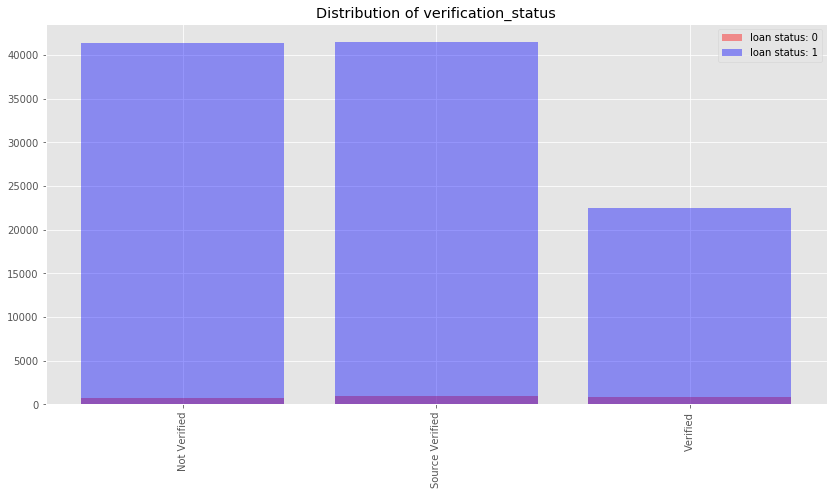

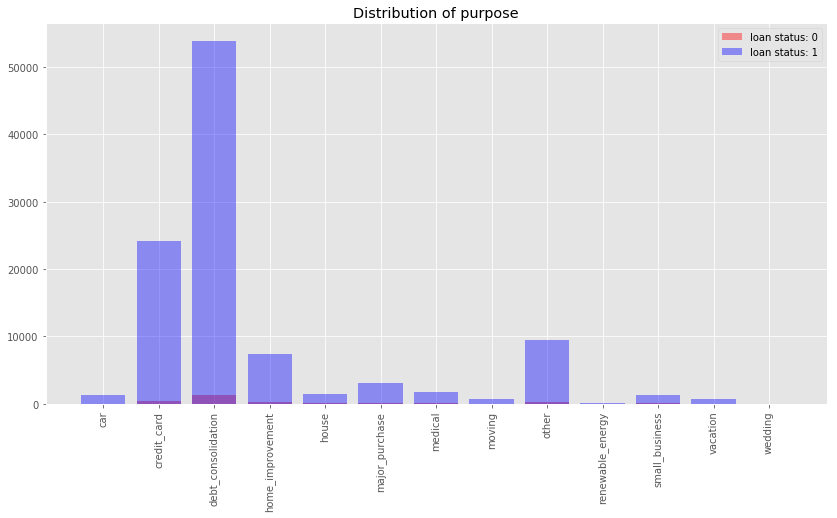

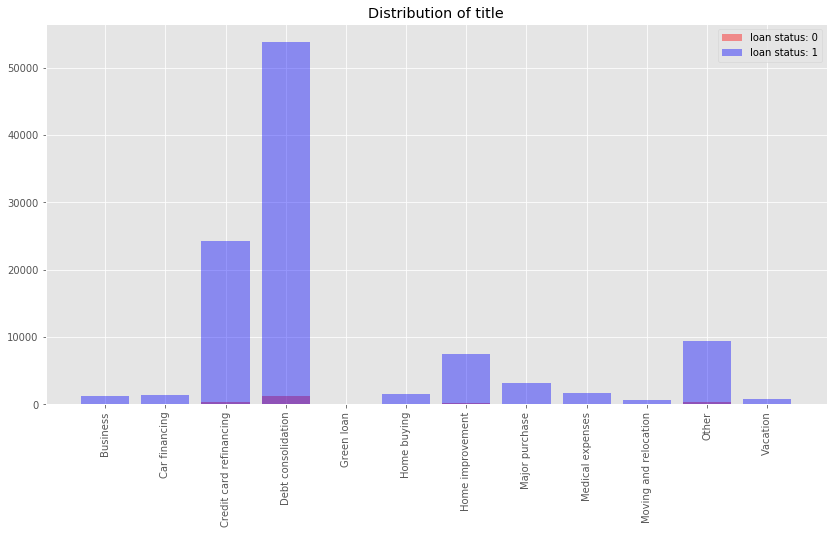

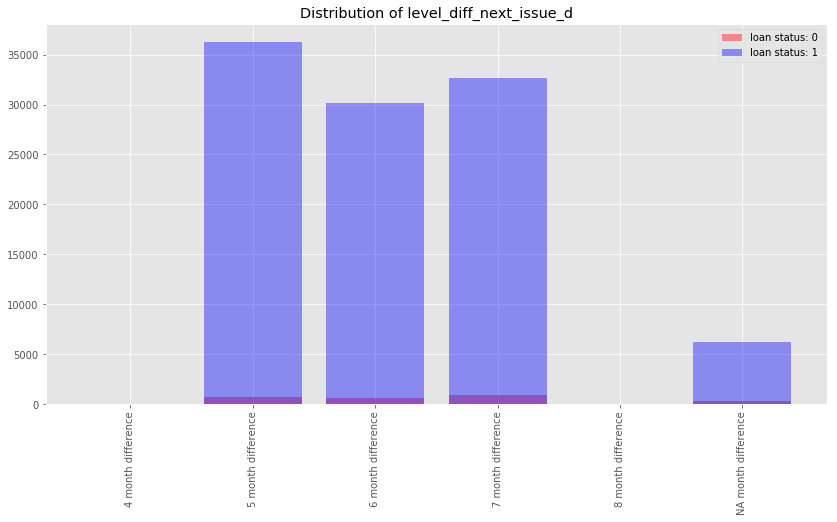

In [242]:
for each in tem_col_name:
    cate_feature_distribution_plot(each)

## 8. Save the final dataset into a csv file for a later model fitting operation

In [181]:
loan.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,numeric_diff_next_issue_d,level_diff_next_issue_d,days_since_last_credit_pull,level_since_last_credit_pull,T_unique_title,days_since_issue,level_since_issue,days_between_max_issue_earliest_cr_line,level_between_max_issue_earliest_cr_line,group_state
0,7000.0,7000.0,7000.0,36 months,7.34,217.23,A,A4,10+ years,MORTGAGE,...,153.0,5 month difference,-122.0,Negative 4 mths,president,0,0 mth,5021,14 yrs,midwest
1,5000.0,5000.0,5000.0,36 months,7.96,156.59,A,A5,10+ years,MORTGAGE,...,153.0,5 month difference,-122.0,Negative 4 mths,manager,0,0 mth,5995,21 yrs,southeast
2,17000.0,17000.0,17000.0,36 months,10.90,555.76,B,B4,10+ years,OWN,...,153.0,5 month difference,-122.0,Negative 4 mths,Other titles,0,0 mth,3865,14 yrs,west
3,20000.0,20000.0,20000.0,36 months,5.31,602.21,A,A1,5 years,OWN,...,153.0,5 month difference,-122.0,Negative 4 mths,owner,0,0 mth,6421,21 yrs,northeast
4,25000.0,25000.0,25000.0,60 months,12.61,563.85,C,C1,10+ years,RENT,...,153.0,5 month difference,-122.0,Negative 4 mths,consultant,0,0 mth,4595,14 yrs,southeast


In [182]:
loan.to_csv('final_LC_loan.csv', encoding='utf-8', index=False)

In [ ]:
# I create another LC loan dataset for Logistic Regression model which is sensitive to outliers and 
# assumes a linear relationship between each feature.
# This dataset contains data without outliers (outlier imputation) and 
# includes'bins' type of features transformed from day difference features (linear relationship assumption)
loan.to_csv('LR_model_final_LC_loan.csv', encoding='utf-8', index=False)